Resizing image to multiples of 128

In [1]:
from torchvision import transforms
import os
from PIL import Image

def load_single_image(image_path, config=''):
    """
    Load and process a single image, applying transformations.
    
    Args:
        image_path: Path to the input image.
        config: The configuration used for transformations.

    Returns:
        img_tensor: Transformed image tensor ready for the model.
        image_name: The name of the image for saving or logging purposes.
    """
    # Load the image
    image = Image.open(image_path).convert('RGB')
    image_name = os.path.basename(image_path)
    
    # Get the image size and crop to the nearest multiple of 128 (optional, as in your Dataset class)
    im_height, im_width = image.size
    if im_height % 128 != 0 or im_width % 128 != 0:
        im_height = im_height - im_height % 128
        im_width = im_width - im_width % 128

    # Apply the same transformations as in the Datasets class
    transform = transforms.Compose([
        transforms.CenterCrop((im_width, im_height)),
        transforms.ToTensor()
    ])

    img_tensor = transform(image).unsqueeze(0)  # Add a batch dimension
    return img_tensor, image_name



Adaptive Patching (Without padding)

In [41]:
import cv2
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import os
import torch

# ---------------------------
# Helper Functions
# ---------------------------
def gaussian_blur(image, kernel_size):
    """Applies Gaussian blur with a square kernel."""
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def edge_detection(image, tl, th):
    """Converts image to grayscale (if needed) and applies Canny edge detection."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    edges = cv2.Canny(gray, tl, th)
    return edges

def quadtree_partition(edge_img, x, y, w, h, current_depth, max_depth, threshold, min_size=32):
    """
    Recursively partitions the image region [x, y, w, h] using a quadtree.
    Returns a list of patch coordinates (x, y, w, h).
    """
    patches = []
    # Stop if patch is too small.
    if w <= min_size or h <= min_size:
        patches.append((x, y, w, h))
        return patches

    # Count edge pixels.
    patch_edges = edge_img[y:y+h, x:x+w]
    edge_count = np.count_nonzero(patch_edges)
    
    # Stop subdividing if edge count is low or maximum depth reached.
    if edge_count <= threshold or current_depth >= max_depth:
        patches.append((x, y, w, h))
    else:
        mid_x = x + w // 2
        mid_y = y + h // 2
        # Top-left
        patches += quadtree_partition(edge_img, x, y, mid_x - x, mid_y - y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Top-right
        patches += quadtree_partition(edge_img, mid_x, y, x + w - mid_x, mid_y - y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Bottom-left
        patches += quadtree_partition(edge_img, x, mid_y, mid_x - x, y + h - mid_y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Bottom-right
        patches += quadtree_partition(edge_img, mid_x, mid_y, x + w - mid_x, y + h - mid_y,
                                      current_depth + 1, max_depth, threshold, min_size)
    return patches

def sort_patches_traditional(patches):
    """
    Sorts patches in traditional reading order: top-to-bottom, left-to-right.
    Each patch is a tuple (x, y, w, h); we sort by y first then x.
    """
    return sorted(patches, key=lambda p: (p[1], p[0]))

def resize_patch(image, patch, Pm):
    """
    Extracts the patch (x, y, w, h) from the image and resizes it to (Pm x Pm).
    """
    x, y, w, h = patch
    patch_img = image[y:y+h, x:x+w]
    resized = cv2.resize(patch_img, (Pm, Pm), interpolation=cv2.INTER_AREA)
    return resized

def random_drop_or_pad_patch_info(patch_info, L, Pm, dtype):
    """
    Given a list of patch_info dictionaries, randomly drops (or pads) so that the length equals L.
    Each dictionary contains keys: 'id', 'coords', 'orig_patch', 'resized_patch'.
    If padding is needed, dummy (black) patches are added.
    """
    num = len(patch_info)
    if num > L:
        patch_info = random.sample(patch_info, L)
    elif num < L:
        # Create a dummy patch (black image)
        # Check whether the image is color or grayscale based on first patch.
        if len(patch_info) > 0 and len(patch_info[0]['resized_patch'].shape) == 3:
            dummy_patch = np.zeros((Pm, Pm, 3), dtype=dtype)
        else:
            dummy_patch = np.zeros((Pm, Pm), dtype=dtype)
        pad_count = L - num
        for i in range(pad_count):
            patch_info.append({
                'id': -1,
                'coords': (-1, -1, 0, 0),
                'orig_patch': dummy_patch,
                'resized_patch': dummy_patch
            })
    return patch_info

def drop_last_or_pad_patch_info(patch_info, L, Pm, dtype):
    """
    Given a list of patch_info dictionaries, drops the last patches (instead of random selection)
    so that the length equals L. If padding is needed, dummy (black) patches are added.
    """
    num = len(patch_info)
    if num > L:
        patch_info = patch_info[:L]  # Keep only the first L patches
    elif num < L:
        # Create a dummy patch (black image)
        if len(patch_info) > 0 and len(patch_info[0]['resized_patch'].shape) == 3:
            dummy_patch = np.zeros((Pm, Pm, 3), dtype=dtype)
        else:
            dummy_patch = np.zeros((Pm, Pm), dtype=dtype)
        pad_count = L - num
        for _ in range(pad_count):
            patch_info.append({
                'id': -1,
                'coords': (-1, -1, 0, 0),
                'orig_patch': dummy_patch,
                'resized_patch': dummy_patch
            })
    return patch_info



def draw_patch_boundaries(image, patch_info):
    """
    Draws rectangle boundaries on a copy of the image using patch coordinates.
    """
    image_copy = image.copy()
    for info in patch_info:
        x, y, w, h = info['coords']
        # Skip dummy patches (with negative coordinates).
        if x < 0 or y < 0:
            continue
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 0, 0), 1)
    return image_copy


def save_patch_info_bin(coord_file, patch_info, rows, cols, original_shape):
    """
    Saves only essential information required for reconstruction in a .bin file.
    """
    with open(coord_file, "wb") as f:
        np.array([rows, cols], dtype=np.uint16).tofile(f)  # Grid size
        np.array(original_shape, dtype=np.uint16).tofile(f)  # Original image shape (H, W, C)
        
        # Save only valid patch coordinates (x, y, w, h) without any dummy patches
        valid_coords = [info['coords'] for info in patch_info if info['coords'][0] >= 0]
        np.array(valid_coords, dtype=np.uint16).tofile(f)  # Patch coordinates

    print("Saved minimal patch info to", coord_file)


def load_patch_info_bin(coord_file):
    """
    Loads only essential information required for reconstruction from a .bin file.
    """
    with open(coord_file, "rb") as f:
        rows, cols = np.fromfile(f, dtype=np.uint16, count=2)  # Read grid size
        original_shape = tuple(np.fromfile(f, dtype=np.uint16, count=3))  # Read original image shape (H, W, C)
        coords = np.fromfile(f, dtype=np.uint16).reshape(-1, 4)  # Read patch coordinates

    return coords, rows, cols, original_shape





# ---------------------------
# Encoder Routine
# ---------------------------
def encode_image(image, kernel_size=5, tl=100, th=200, v=50, H=10, Pm=32, L=64,
                 grid_image_file="patches_grid.png", coord_file="patch_coords.bin"):
    """
    Encoder:
      - Computes adaptive patches from the input image.
      - Sorts patches in traditional order.
      - Resizes patches to Pm x Pm.
      - Randomly drops or pads them to exactly L patches.
      - Arranges the final patches in a grid.
      - Saves the grid image and the patch coordinates vector (with extra info) to disk.
    """
    # Stage 1: Preprocessing (blur and edge detection)
    blurred = gaussian_blur(image, kernel_size)
    edges = edge_detection(blurred, tl, th)
    
    # Stage 2: Quadtree partitioning
    h_img, w_img = edges.shape[:2]
    patches_coords = quadtree_partition(edges, 0, 0, w_img, h_img,
                                          current_depth=0, max_depth=H,
                                          threshold=v, min_size=32)
    
    # Stage 3: Sort patches in traditional order (top-to-bottom, left-to-right)
    sorted_coords = sort_patches_traditional(patches_coords)
    
    # Stage 4: Build patch_info list (store coordinates, original patch, and resized patch)
    patch_info = []
    for idx, coord in enumerate(sorted_coords):
        x, y, w, h = coord
        orig_patch = image[y:y+h, x:x+w]
        resized_patch = resize_patch(image, coord, Pm)
        patch_info.append({
            'id': idx,
            'coords': coord,         # (x, y, w, h)
            'orig_patch': orig_patch,
            'resized_patch': resized_patch
        })
    
    print("Number of adaptive patches created:", len(patch_info))
    
    # Stage 5: Randomly drop or pad patch_info to exactly L patches.
    #patch_info = random_drop_or_pad_patch_info(patch_info, L, Pm, image.dtype)
    patch_info = drop_last_or_pad_patch_info(patch_info, L, Pm, image.dtype)

    
    # Stage 6: Arrange the resized patches in a grid image.
    # grid_img, rows, cols = arrange_patches_in_grid_from_info(patch_info, Pm)

    grid_img, rows, cols = arrange_patches_in_grid_from_info(patch_info, Pm)
    print(f"Final Grid Size: {rows * Pm} x {cols * Pm} (Multiple of 128)")

    
    # Stage 7: Save the grid image.
    cv2.imwrite(grid_image_file, grid_img)
    print("Saved grid image to", grid_image_file)

    
    # Stage 8: Save the coordinate vector and auxiliary info in a binary (npz) file.
    # Extract coordinates from the final patch_info (in the same order as in the grid).
    coords_arr = np.array([info['coords'] for info in patch_info])

    save_patch_info_bin(coord_file, patch_info, rows, cols, image.shape)



    
    # (Optional) Display intermediate results.
    # Display grid of resized patches.
    grid_img_rgb = cv2.cvtColor(grid_img, cv2.COLOR_BGR2RGB) if len(grid_img.shape) == 3 else grid_img
    plt.figure(figsize=(8,8))
    plt.imshow(grid_img_rgb)
    plt.title("Adaptive Patching Grid")
    #plt.axis("off")
    plt.show()
    
    # Display original image with patch boundaries.
    image_with_boundaries = draw_patch_boundaries(image, patch_info)
    image_with_boundaries_rgb = cv2.cvtColor(image_with_boundaries, cv2.COLOR_BGR2RGB) if len(image_with_boundaries.shape)==3 else image_with_boundaries
    plt.figure(figsize=(8,8))
    plt.imshow(image_with_boundaries_rgb)
    plt.title("Original Image with Patch Boundaries")
    #plt.axis("off")
    plt.show()

# ---------------------------
# Decoder Routine
# ---------------------------
def decode_image(grid_image_file="patches_grid.png", coord_file="patch_coords.bin", Pm=8):
    """
    Decoder:
      - Loads the grid image (composed of resized patches) and the patch coordinate vector.
      - Splits the grid image into individual patches.
      - For each patch, uses its stored coordinate (x, y, w, h) to resize it back to its original size.
      - Reconstructs the original image by placing each patch at its correct location.
    """
    # Load grid image.
    grid_img = cv2.imread(grid_image_file)
    if grid_img is None:
        raise ValueError("Grid image not found at " + grid_image_file)
    
    coords, rows, cols, original_shape = load_patch_info_bin(coord_file)


    
    L = coords.shape[0]
    
    # Split grid image into patches.
    grid_patches = []
    for r in range(rows):
        for c in range(cols):
            idx = r * cols + c
            if idx >= L:
                break
            patch = grid_img[r*Pm:(r+1)*Pm, c*Pm:(c+1)*Pm]
            grid_patches.append(patch)
    
    # Reconstruct original image.
    reconstructed = np.zeros(original_shape, dtype=grid_img.dtype)
    for idx, patch in enumerate(grid_patches):
        x, y, w, h = coords[idx]
        # Skip dummy patches (with invalid coordinates).
        if x < 0 or y < 0 or w == 0 or h == 0:
            continue
        # Resize the patch from fixed size Pm to its original size (w x h).
        patch_resized = cv2.resize(patch, (w, h), interpolation=cv2.INTER_AREA)
        # Place the patch into the reconstructed image.
        reconstructed[y:y+h, x:x+w] = patch_resized
    
    # Display the reconstructed image.
    # Convert to RGB for display if needed.
    if len(reconstructed.shape) == 3:
        reconstructed_rgb = cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB)
    else:
        reconstructed_rgb = reconstructed
    plt.figure(figsize=(8,8))
    plt.imshow(reconstructed_rgb)
    plt.title("Reconstructed Image from Patches")
    #plt.axis("off")
    plt.show()

    #Save the reconstructed image
    #cv2.imwrite('reconstructed_image.png', reconstructed)

    reconstructed_tensor = torch.from_numpy(reconstructed_rgb / 255.0).permute(2, 0, 1).unsqueeze(0).float()
    
    return reconstructed_tensor



def arrange_patches_in_grid_from_info(patch_info, Pm):
    """
    Arranges a list of patch dictionaries (each containing a 'resized_patch' of shape Pm x Pm)
    into a grid image with dimensions that are multiples of 128.
    Returns the grid image along with the grid dimensions (rows, cols).
    """
    L = len(patch_info)
    
    # Compute initial estimate of rows and cols
    base_size = 128 // Pm  # Each 128 block can fit base_size patches
    rows = base_size
    while rows * rows < L:
        rows += base_size

    cols = math.ceil(L / rows)

    # Adjust rows and cols to be multiples of 128
    rows = math.ceil(rows * Pm / 128) * (128 // Pm)
    cols = math.ceil(cols * Pm / 128) * (128 // Pm)

    final_L = rows * cols  # Total patches after adjustment

    # Pad patch_info with dummy patches if needed
    dtype = patch_info[0]['resized_patch'].dtype
    dummy_patch = np.zeros((Pm, Pm, 3), dtype=dtype)
    while len(patch_info) < final_L:
        patch_info.append({
            'id': -1,
            'coords': (-1, -1, 0, 0),
            'orig_patch': dummy_patch,
            'resized_patch': dummy_patch
        })

    # Create grid image
    if len(patch_info[0]['resized_patch'].shape) == 3:
        channels = patch_info[0]['resized_patch'].shape[2]
        grid_img = np.zeros((rows * Pm, cols * Pm, channels), dtype=dtype)
    else:
        grid_img = np.zeros((rows * Pm, cols * Pm), dtype=dtype)
    
    # Fill the grid
    for i, info in enumerate(patch_info):
        row = i // cols
        col = i % cols
        grid_img[row * Pm:(row + 1) * Pm, col * Pm:(col + 1) * Pm] = info['resized_patch']

    return grid_img, rows, cols

# ---------------------------
# Main: Choose to Encode or Decode
# ---------------------------
if __name__ == "__main__":
    
    
    image_path = 'Datasets/Clic2021/01.png'
    image_path = 'Datasets/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR/0862.png'
    #image_path = 'Datasets/Kodak/kodim23.png'

    input_image, image_name= load_single_image(image_path)
    resized_image_np = input_image.squeeze(0).permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    resized_image_np = (resized_image_np * 255).astype(np.uint8)  # Convert to uint8 for OpenCV
    # Convert RGB to BGR for OpenCV compatibility
    image = cv2.cvtColor(resized_image_np, cv2.COLOR_RGB2BGR)
    
    
    # image_path = "Datasets/Kodak/kodim23.png"  # Replace with your input image path.
    # image_path = 'Datasets/Clic2021/01.png'
    # image = cv2.imread(image_path)
    
    if image is None:
        raise ValueError("Input image not found at " + image_path)
    
    # Call the encoder.
    encode_image(image,
                    kernel_size=1,
                    tl=100, th=200,
                    v=50,       # quadtree edge threshold
                    H=5,       # maximum quadtree depth
                    Pm=32,      # fixed resized patch size (32x32)
                    L=440,       # number of patches in the grid
                    grid_image_file="patches_grid.png",
                    coord_file="patch_coords.bin")
        
    
    reconstructed_image = decode_image(grid_image_file="patches_grid.png",
                                             coord_file="patch_coords.bin", Pm=32)

NameError: name 'load_single_image' is not defined

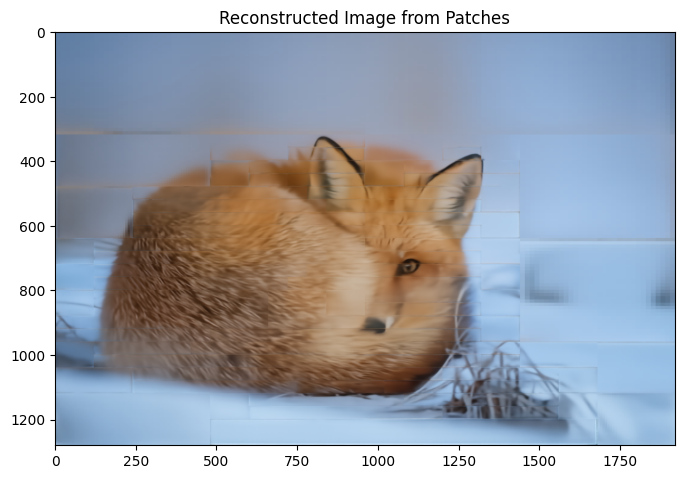

In [28]:
reconstructed_image = decode_image(grid_image_file="recon/reconstructed_patches_grid.png",
                                    coord_file="patch_coords.bin", Pm=32)

In [6]:
import torch
import torch.nn.functional as F

def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1 * 255., img2 * 255.)
    psnr = 10 * torch.log10(255.0 ** 2 / mse)
    return psnr

# input_image = load_single_image(image_path)[0]
# reconstructed_image = load_single_image('reconstructed_image.png')[0]

psnr_value = calculate_psnr(input_image, reconstructed_image)

print(f"PSNR: {psnr_value:.2f} dB")

PSNR: 35.02 dB


Padding code to make the boundaries smoother

Number of adaptive patches created: 178
Final Grid Size: 512 x 384 (Multiple of 128)
Saved grid image to patches_grid.png
Saved minimal patch info to patch_coords.bin


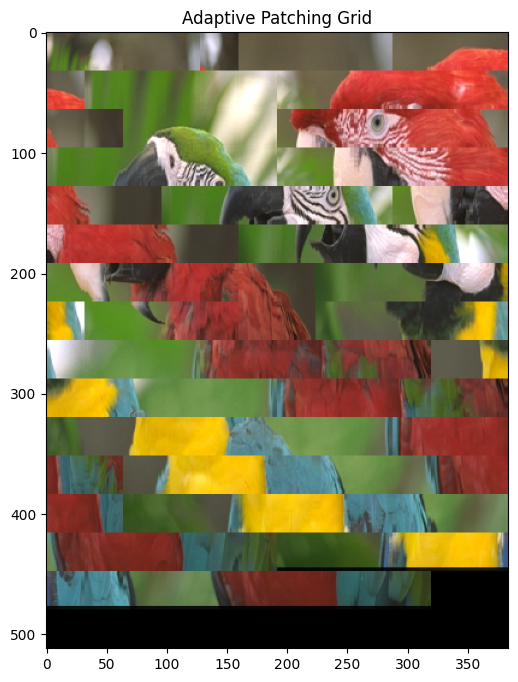

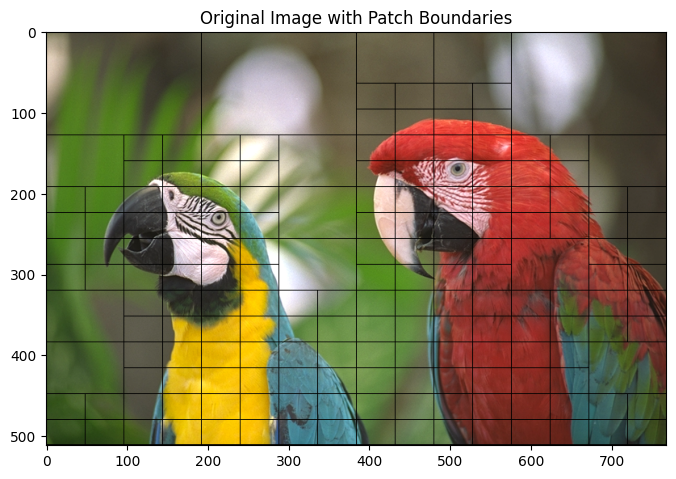

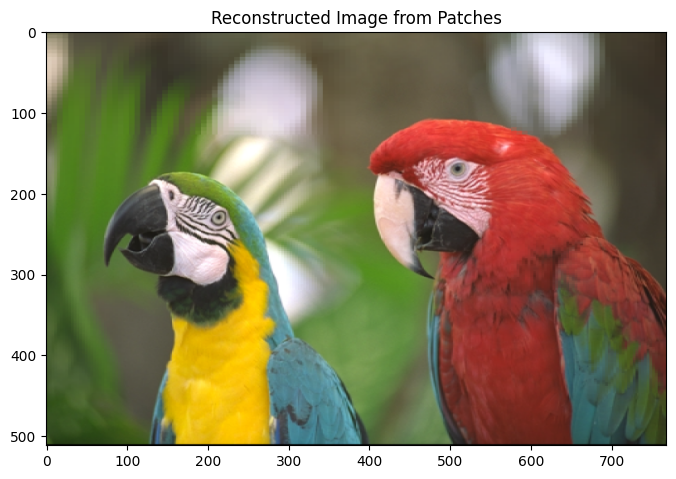

In [3]:
import cv2
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import os
import torch

# ---------------------------
# Helper Functions
# ---------------------------
def gaussian_blur(image, kernel_size):
    """Applies Gaussian blur with a square kernel."""
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def edge_detection(image, tl, th):
    """Converts image to grayscale (if needed) and applies Canny edge detection."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    edges = cv2.Canny(gray, tl, th)
    return edges

def quadtree_partition(edge_img, x, y, w, h, current_depth, max_depth, threshold, min_size=32):
    """
    Recursively partitions the image region [x, y, w, h] using a quadtree.
    Returns a list of patch coordinates (x, y, w, h).
    """
    patches = []
    # Stop if the patch is too small.
    if w <= min_size or h <= min_size:
        patches.append((x, y, w, h))
        return patches

    # Count edge pixels.
    patch_edges = edge_img[y:y+h, x:x+w]
    edge_count = np.count_nonzero(patch_edges)
    
    # Stop subdividing if edge count is low or maximum depth reached.
    if edge_count <= threshold or current_depth >= max_depth:
        patches.append((x, y, w, h))
    else:
        mid_x = x + w // 2
        mid_y = y + h // 2
        # Top-left
        patches += quadtree_partition(edge_img, x, y, mid_x - x, mid_y - y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Top-right
        patches += quadtree_partition(edge_img, mid_x, y, x + w - mid_x, mid_y - y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Bottom-left
        patches += quadtree_partition(edge_img, x, mid_y, mid_x - x, y + h - mid_y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Bottom-right
        patches += quadtree_partition(edge_img, mid_x, mid_y, x + w - mid_x, y + h - mid_y,
                                      current_depth + 1, max_depth, threshold, min_size)
    return patches

def sort_patches_traditional(patches):
    """
    Sorts patches in traditional reading order: top-to-bottom, left-to-right.
    Each patch is a tuple (x, y, w, h); we sort by y first then x.
    """
    return sorted(patches, key=lambda p: (p[1], p[0]))

def interleave_bits(n):
    """Helper to interleave bits of a 16-bit integer."""
    n &= 0xFFFF
    n = (n | (n << 8)) & 0x00FF00FF
    n = (n | (n << 4)) & 0x0F0F0F0F
    n = (n | (n << 2)) & 0x33333333
    n = (n | (n << 1)) & 0x55555555
    return n

def morton_code(x, y):
    """
    Computes the Morton code (Z-order) for the (x, y) coordinates.
    Here we interleave the bits of x and y.
    """
    return (interleave_bits(y) << 1) | interleave_bits(x)

def sort_patches_by_morton(patches):
    """
    Sorts a list of patch coordinates (x, y, w, h) using the Morton Z-order.
    We compute the Morton code based on the patch’s center.
    """
    patches_with_code = []
    for (x, y, w, h) in patches:
        center_x = x + w // 2
        center_y = y + h // 2
        code = morton_code(center_x, center_y)
        patches_with_code.append(((x, y, w, h), code))
    patches_with_code.sort(key=lambda item: item[1])
    sorted_patches = [item[0] for item in patches_with_code]
    return sorted_patches


# def resize_patch(image, patch, Pm, padding=2):
#     """
#     Extracts the patch (x, y, w, h) from the image and resizes it.
#     First, it resizes the patch to a central region of size (Pm x Pm).
#     Then it creates a padded patch of size (Pm + 2*padding x Pm + 2*padding)
#     where the border is obtained by a simple interpolation.
#     """
#     x, y, w, h = patch
#     patch_img = image[y:y+h, x:x+w]
#     resized_center = cv2.resize(patch_img, (Pm, Pm), interpolation=cv2.INTER_AREA)
#     padded_size = Pm + 2 * padding
#     # Initially resize to the padded size (this gives a rough estimate for borders)
#     resized_patch = cv2.resize(patch_img, (padded_size, padded_size), interpolation=cv2.INTER_AREA)
#     # Replace the central region with the correctly resized patch
#     resized_patch[padding:padding+Pm, padding:padding+Pm] = resized_center
#     return resized_patch

# def resize_patch(image, patch, Pm, padding=2):
#     """
#     Extracts the patch (x, y, w, h) from the image and resizes it.
#     Instead of simple interpolation-based resizing, this function:
#       - Resizes the patch to Pm × Pm for uniform processing.
#       - Expands it by padding with edge-aware extensions (mirroring edge pixels).
#       - Returns the padded patch of size (Pm + 2*padding) × (Pm + 2*padding).

#     This ensures smoother transitions at patch edges, reducing artifacts when reconstructing the image.
#     """
#     x, y, w, h = patch
#     patch_img = image[y:y+h, x:x+w]

#     # Resize patch to Pm × Pm
#     resized_center = cv2.resize(patch_img, (Pm, Pm), interpolation=cv2.INTER_AREA)

#     # Define new padded size
#     padded_size = Pm + 2 * padding
#     padded_patch = np.zeros((padded_size, padded_size, 3), dtype=image.dtype)

#     # Insert resized patch in the center
#     padded_patch[padding:padding+Pm, padding:padding+Pm] = resized_center

#     # Edge-aware padding using mirroring or replication
#     # Top and bottom padding
#     padded_patch[:padding, padding:padding+Pm] = resized_center[0:1, :, :]  # Copy top row
#     padded_patch[-padding:, padding:padding+Pm] = resized_center[-1:, :, :]  # Copy bottom row

#     # Left and right padding
#     padded_patch[padding:padding+Pm, :padding] = resized_center[:, 0:1, :]  # Copy left column
#     padded_patch[padding:padding+Pm, -padding:] = resized_center[:, -1:, :]  # Copy right column

#     # Corner regions (copy nearest edge pixels)
#     padded_patch[:padding, :padding] = resized_center[0, 0]  # Top-left corner
#     padded_patch[:padding, -padding:] = resized_center[0, -1]  # Top-right corner
#     padded_patch[-padding:, :padding] = resized_center[-1, 0]  # Bottom-left corner
#     padded_patch[-padding:, -padding:] = resized_center[-1, -1]  # Bottom-right corner

#     return padded_patch

def resize_patch(image, patch, Pm, padding=2):
    """
    Extracts the patch (x, y, w, h) from the image and resizes it.
    - Resizes the patch to Pm × Pm for uniform processing.
    - Expands it by padding with edge-aware extensions (mirroring edge pixels).
    - Returns the padded patch of size (Pm + 2*padding) × (Pm + 2*padding).

    If padding=0, it simply returns the resized patch.
    """
    x, y, w, h = patch
    patch_img = image[y:y+h, x:x+w]

    # Resize patch to Pm × Pm
    resized_center = cv2.resize(patch_img, (Pm, Pm), interpolation=cv2.INTER_AREA)

    # If padding is 0, return the resized patch directly
    if padding == 0:
        return resized_center

    # Define new padded size
    padded_size = Pm + 2 * padding
    padded_patch = np.zeros((padded_size, padded_size, 3), dtype=image.dtype)

    # Insert resized patch in the center
    padded_patch[padding:padding+Pm, padding:padding+Pm] = resized_center

    # Edge-aware padding using mirroring or replication
    # Top and bottom padding
    padded_patch[:padding, padding:padding+Pm] = resized_center[0:1, :, :]  # Copy top row
    padded_patch[-padding:, padding:padding+Pm] = resized_center[-1:, :, :]  # Copy bottom row

    # Left and right padding
    padded_patch[padding:padding+Pm, :padding] = resized_center[:, 0:1, :]  # Copy left column
    padded_patch[padding:padding+Pm, -padding:] = resized_center[:, -1:, :]  # Copy right column

    # Corner regions (copy nearest edge pixels)
    padded_patch[:padding, :padding] = resized_center[0, 0]  # Top-left corner
    padded_patch[:padding, -padding:] = resized_center[0, -1]  # Top-right corner
    padded_patch[-padding:, :padding] = resized_center[-1, 0]  # Bottom-left corner
    padded_patch[-padding:, -padding:] = resized_center[-1, -1]  # Bottom-right corner

    return padded_patch


def drop_last_or_pad_patch_info(patch_info, L, patch_size, dtype):
    """
    Given a list of patch_info dictionaries, drops extra patches (if > L) or pads with dummy patches
    so that the final list length equals L.
    """
    num = len(patch_info)
    if num > L:
        patch_info = patch_info[:L]  # Keep only the first L patches
    elif num < L:
        # Create a dummy patch (black image)
        if len(patch_info) > 0 and len(patch_info[0]['resized_patch'].shape) == 3:
            dummy_patch = np.zeros((patch_size, patch_size, 3), dtype=dtype)
        else:
            dummy_patch = np.zeros((patch_size, patch_size), dtype=dtype)
        for _ in range(L - num):
            patch_info.append({
                'id': -1,
                'coords': (-1, -1, 0, 0),
                'orig_patch': dummy_patch,
                'resized_patch': dummy_patch
            })
    return patch_info

def draw_patch_boundaries(image, patch_info):
    """
    Draws rectangle boundaries on a copy of the image using patch coordinates.
    """
    image_copy = image.copy()
    for info in patch_info:
        x, y, w, h = info['coords']
        # Skip dummy patches.
        if x < 0 or y < 0:
            continue
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 0, 0), 1)
    return image_copy

def save_patch_info_bin(coord_file, patch_info, rows, cols, original_shape):
    """
    Saves grid size, original image shape, and valid patch coordinates to a binary file.
    """
    with open(coord_file, "wb") as f:
        np.array([rows, cols], dtype=np.uint16).tofile(f)  # Grid size
        np.array(original_shape, dtype=np.uint16).tofile(f)  # Original image shape (H, W, C)
        valid_coords = [info['coords'] for info in patch_info if info['coords'][0] >= 0]
        np.array(valid_coords, dtype=np.uint16).tofile(f)  # Patch coordinates
    print("Saved minimal patch info to", coord_file)

def load_patch_info_bin(coord_file):
    """
    Loads grid size, original image shape, and patch coordinates from a binary file.
    """
    with open(coord_file, "rb") as f:
        rows, cols = np.fromfile(f, dtype=np.uint16, count=2)
        original_shape = tuple(np.fromfile(f, dtype=np.uint16, count=3))
        coords = np.fromfile(f, dtype=np.uint16).reshape(-1, 4)
    return coords, rows, cols, original_shape

def arrange_patches_in_grid_from_info(patch_info, patch_size):
    """
    Arranges a list of patch dictionaries (each with a 'resized_patch' of size (patch_size x patch_size))
    into a grid image. This function computes rows and columns so that the grid dimensions are multiples
    of 128 and match the expected resolution.
    
    For example, with patch_size = 32 (i.e. Pm=28 and padding=2), L=192 patches, the grid will be:
      - rows = 16 (i.e. 16 * 32 = 512 pixels in one dimension)
      - cols = 12 (i.e. 12 * 32 = 384 pixels in the other dimension)
    """
    L = len(patch_info)
    # Determine a base size using 128 as a reference (each 128 block fits patch_size pixels)
    base_size = 128 // patch_size  # For patch_size=32, base_size=4
    rows = base_size
    while rows * rows < L:
        rows += base_size
    cols = math.ceil(L / rows)
    # Adjust rows and cols so that the grid dimensions are multiples of (128 // patch_size)
    factor = 128 // patch_size
    rows = math.ceil((rows * patch_size) / 128) * factor
    cols = math.ceil((cols * patch_size) / 128) * factor

    grid_height = rows * patch_size
    grid_width = cols * patch_size

    grid_img = np.zeros((grid_height, grid_width, 3), dtype=np.uint8)
    for idx, info in enumerate(patch_info):
        row = idx // cols
        col = idx % cols
        grid_img[row * patch_size:(row+1) * patch_size, col * patch_size:(col+1) * patch_size] = info['resized_patch']
    return grid_img, rows, cols

# ---------------------------
# Encoder Routine
# ---------------------------
def encode_image_adaptive(image, kernel_size=1, tl=100, th=200, v=50, H=5, Pm=28, L=192,
                          grid_image_file="patches_grid.png", coord_file="patch_coords.bin", padding=2):
    """
    Encoder:
      - Computes adaptive patches using a quadtree.
      - Resizes patches to a fixed size with added padding.
      - Pads (or drops) patch_info so that exactly L patches are arranged.
      - Arranges patches into a grid whose dimensions are multiples of 128.
      - Saves the grid image and patch coordinate info.
    """
    # Stage 1: Preprocessing
    blurred = gaussian_blur(image, kernel_size)
    edges = edge_detection(blurred, tl, th)
    
    # Stage 2: Quadtree partitioning
    h_img, w_img = edges.shape[:2]
    patches_coords = quadtree_partition(edges, 0, 0, w_img, h_img, 0, H, v, min_size=32)
    
    # Stage 3: Sort patches in reading order
    sorted_coords = sort_patches_traditional(patches_coords)
    #sorted_coords = sort_patches_by_morton(patches_coords)
    
    # Stage 4: Build patch_info list (store coordinates, original patch, and resized (padded) patch)
    patch_info = []
    for idx, coord in enumerate(sorted_coords):
        x, y, w, h = coord
        orig_patch = image[y:y+h, x:x+w]
        resized_patch = resize_patch(image, coord, Pm, padding)
        patch_info.append({
            'id': idx,
            'coords': coord,
            'orig_patch': orig_patch,
            'resized_patch': resized_patch
        })
    print("Number of adaptive patches created:", len(patch_info))

    if L is None:
        L = len(patch_info)
    
    # The effective patch size after padding
    effective_patch_size = Pm + 2 * padding
    patch_info = drop_last_or_pad_patch_info(patch_info, L, effective_patch_size, image.dtype)
    
    # Stage 5: Arrange patches into a grid.
    grid_img, rows, cols = arrange_patches_in_grid_from_info(patch_info, effective_patch_size)
    #print(f"Final Grid Size: {grid_img.shape[1]} x {grid_img.shape[0]} (Width x Height)")
    print(f"Final Grid Size: {rows * effective_patch_size} x {cols * effective_patch_size} (Multiple of 128)")
    
    # Stage 6: Save grid image and coordinate file.
    cv2.imwrite(grid_image_file, grid_img)
    print("Saved grid image to", grid_image_file)
    save_patch_info_bin(coord_file, patch_info, rows, cols, image.shape)
    
    # (Optional) Display the results.
    grid_img_rgb = cv2.cvtColor(grid_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,8))
    plt.imshow(grid_img_rgb)
    plt.title("Adaptive Patching Grid")
    plt.show()
    
    image_with_boundaries = draw_patch_boundaries(image, patch_info)
    image_with_boundaries_rgb = cv2.cvtColor(image_with_boundaries, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,8))
    plt.imshow(image_with_boundaries_rgb)
    plt.title("Original Image with Patch Boundaries")
    plt.show()

# ---------------------------
# Decoder Routine
# ---------------------------
def decode_image_adaptive(grid_image_file="patches_grid.png", coord_file="patch_coords.bin", Pm=28, padding=2):
    """
    Decoder:
      - Loads the grid image and patch coordinate info.
      - Splits the grid image back into patches.
      - Uses stored coordinates to resize each patch back to its original size.
      - Reconstructs the original image.
    """
    grid_img = cv2.imread(grid_image_file)
    if grid_img is None:
        raise ValueError("Grid image not found at " + grid_image_file)
    
    effective_patch_size = Pm + 2 * padding
    coords, rows, cols, original_shape = load_patch_info_bin(coord_file)
    L = coords.shape[0]
    
    # Split grid image into patches.
    grid_patches = []
    for r in range(rows):
        for c in range(cols):
            idx = r * cols + c
            if idx >= L:
                break
            patch = grid_img[r*effective_patch_size:(r+1)*effective_patch_size,
                              c*effective_patch_size:(c+1)*effective_patch_size]
            grid_patches.append(patch)
    
    # Reconstruct the original image.
    reconstructed = np.zeros(original_shape, dtype=grid_img.dtype)
    for idx, patch in enumerate(grid_patches):
        x, y, w, h = coords[idx]
        if x < 0 or y < 0 or w == 0 or h == 0:
            continue
        cropped_patch = patch[padding:padding+Pm, padding:padding+Pm]
        if cropped_patch.size == 0:
            continue
        patch_resized = cv2.resize(cropped_patch, (w, h), interpolation=cv2.INTER_AREA)
        reconstructed[y:y+h, x:x+w] = patch_resized
    
    reconstructed_rgb = cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,8))
    plt.imshow(reconstructed_rgb)
    plt.title("Reconstructed Image from Patches")
    plt.show()

    reconstructed_tensor = torch.from_numpy(reconstructed_rgb / 255.0).permute(2, 0, 1).unsqueeze(0).float()
    
    return reconstructed_tensor
    
   

# ---------------------------
# Main Routine
# ---------------------------
if __name__ == "__main__":
    # Change this image path as needed.
    image_path = 'Datasets/Kodak/kodim23.png'
    #image_path = 'Datasets/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR/0862.png'
    # image_path = 'Datasets/Clic2021/01.png'
    #image_path = 'Datasets/Kodak/kodim25.jpeg'


    # image = cv2.imread(image_path)


    input_image, image_name= load_single_image(image_path)
    resized_image_np = input_image.squeeze(0).permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    resized_image_np = (resized_image_np * 255).astype(np.uint8)  # Convert to uint8 for OpenCV
    # Convert RGB to BGR for OpenCV compatibility
    image = cv2.cvtColor(resized_image_np, cv2.COLOR_RGB2BGR)


    if image is None:
        raise ValueError("Input image not found at " + image_path)
    
    
    encode_image_adaptive(image,
                          kernel_size=1,
                          tl=100, th=200,
                          v=50,       # quadtree edge threshold
                          H=5,        # maximum quadtree depth
                          Pm=28,      # base patch size before padding
                          L=None,      # number of patches in the grid   (If None, it will be set to the number of adaptive patches)
                          grid_image_file="patches_grid.png",
                          coord_file="patch_coords.bin",
                          padding=2)
    
    reconstructed_image = decode_image_adaptive(grid_image_file="patches_grid.png",
                                                  coord_file="patch_coords.bin",
                                                  Pm=28,
                                                  padding=2)


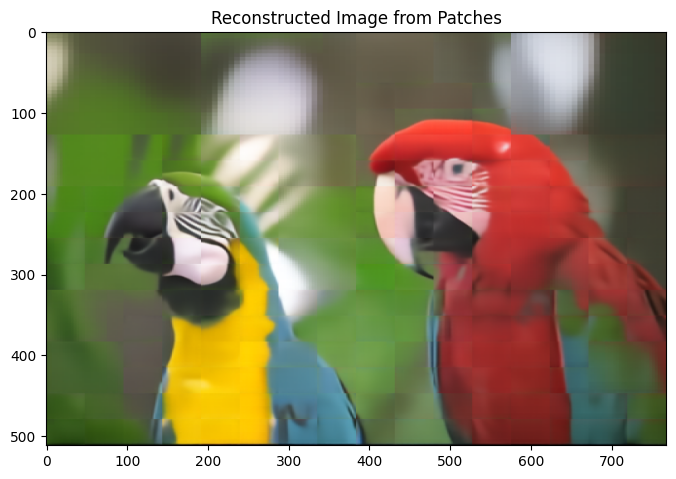

In [68]:
reconstructed_image = decode_image_adaptive(grid_image_file="recon/reconstructed_patches_grid.png",
                                                  coord_file="patch_coords.bin",
                                                  Pm=28,
                                                  padding=2)


In [70]:
import torch
import torch.nn.functional as F

def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1 * 255., img2 * 255.)
    psnr = 10 * torch.log10(255.0 ** 2 / mse)
    return psnr

# input_image = load_single_image(image_path)[0]
# reconstructed_image = load_single_image('reconstructed_image.png')[0]

psnr_value = calculate_psnr(input_image, reconstructed_image)

print(f"PSNR: {psnr_value:.2f} dB")

PSNR: 27.55 dB


Patch Numbering

Number of adaptive patches created: 178
Final Grid Size: 512 x 384 (Multiple of 128)
Saved grid image to patches_grid.png
Saved minimal patch info to patch_coords.bin


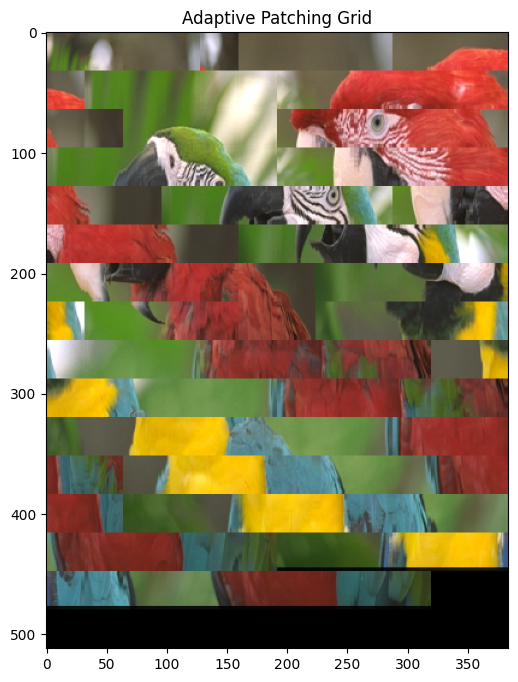

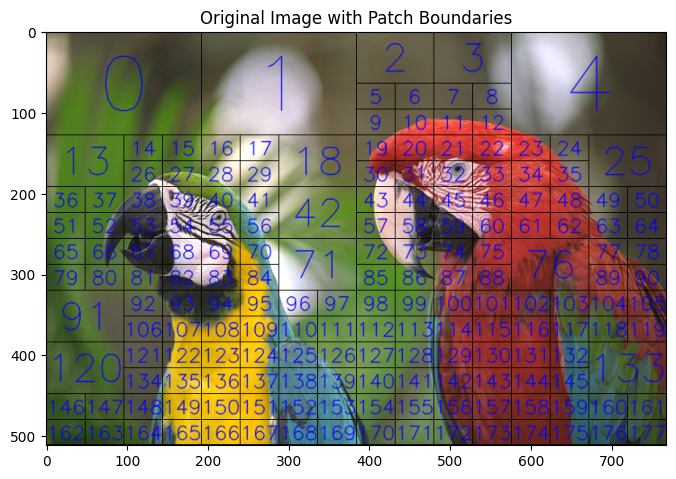

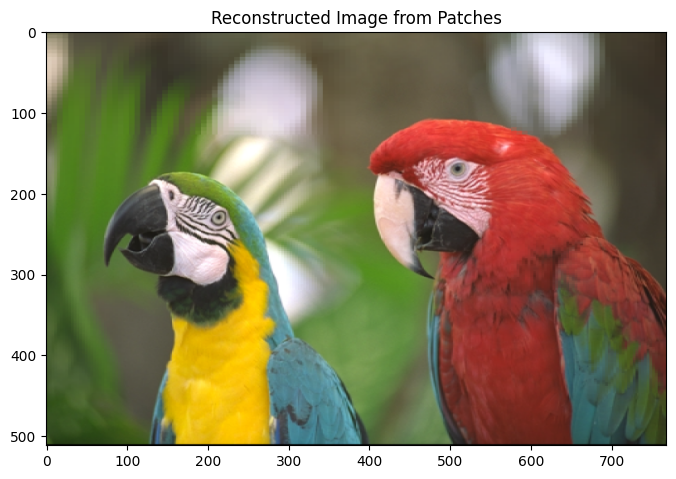

In [79]:
import cv2
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import os

# ---------------------------
# Helper Functions
# ---------------------------
def gaussian_blur(image, kernel_size):
    """Applies Gaussian blur with a square kernel."""
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def edge_detection(image, tl, th):
    """Converts image to grayscale (if needed) and applies Canny edge detection."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    edges = cv2.Canny(gray, tl, th)
    return edges

def quadtree_partition(edge_img, x, y, w, h, current_depth, max_depth, threshold, min_size=32):
    """
    Recursively partitions the image region [x, y, w, h] using a quadtree.
    Returns a list of patch coordinates (x, y, w, h).
    """
    patches = []
    # Stop if the patch is too small.
    if w <= min_size or h <= min_size:
        patches.append((x, y, w, h))
        return patches

    # Count edge pixels.
    patch_edges = edge_img[y:y+h, x:x+w]
    edge_count = np.count_nonzero(patch_edges)
    
    # Stop subdividing if edge count is low or maximum depth reached.
    if edge_count <= threshold or current_depth >= max_depth:
        patches.append((x, y, w, h))
    else:
        mid_x = x + w // 2
        mid_y = y + h // 2
        # Top-left
        patches += quadtree_partition(edge_img, x, y, mid_x - x, mid_y - y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Top-right
        patches += quadtree_partition(edge_img, mid_x, y, x + w - mid_x, mid_y - y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Bottom-left
        patches += quadtree_partition(edge_img, x, mid_y, mid_x - x, y + h - mid_y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Bottom-right
        patches += quadtree_partition(edge_img, mid_x, mid_y, x + w - mid_x, y + h - mid_y,
                                      current_depth + 1, max_depth, threshold, min_size)
    return patches

def sort_patches_traditional(patches):
    """
    Sorts patches in traditional reading order: top-to-bottom, left-to-right.
    Each patch is a tuple (x, y, w, h); we sort by y first then x.
    """
    return sorted(patches, key=lambda p: (p[1], p[0]))

def interleave_bits(n):
    """Helper to interleave bits of a 16-bit integer."""
    n &= 0xFFFF
    n = (n | (n << 8)) & 0x00FF00FF
    n = (n | (n << 4)) & 0x0F0F0F0F
    n = (n | (n << 2)) & 0x33333333
    n = (n | (n << 1)) & 0x55555555
    return n

def morton_code(x, y):
    """
    Computes the Morton code (Z-order) for the (x, y) coordinates.
    Here we interleave the bits of x and y.
    """
    return (interleave_bits(y) << 1) | interleave_bits(x)

def sort_patches_by_morton(patches):
    """
    Sorts a list of patch coordinates (x, y, w, h) using the Morton Z-order.
    We compute the Morton code based on the patch’s center.
    """
    patches_with_code = []
    for (x, y, w, h) in patches:
        center_x = x + w // 2
        center_y = y + h // 2
        code = morton_code(center_x, center_y)
        patches_with_code.append(((x, y, w, h), code))
    patches_with_code.sort(key=lambda item: item[1])
    sorted_patches = [item[0] for item in patches_with_code]
    return sorted_patches


# def resize_patch(image, patch, Pm, padding=2):
#     """
#     Extracts the patch (x, y, w, h) from the image and resizes it.
#     First, it resizes the patch to a central region of size (Pm x Pm).
#     Then it creates a padded patch of size (Pm + 2*padding x Pm + 2*padding)
#     where the border is obtained by a simple interpolation.
#     """
#     x, y, w, h = patch
#     patch_img = image[y:y+h, x:x+w]
#     resized_center = cv2.resize(patch_img, (Pm, Pm), interpolation=cv2.INTER_AREA)
#     padded_size = Pm + 2 * padding
#     # Initially resize to the padded size (this gives a rough estimate for borders)
#     resized_patch = cv2.resize(patch_img, (padded_size, padded_size), interpolation=cv2.INTER_AREA)
#     # Replace the central region with the correctly resized patch
#     resized_patch[padding:padding+Pm, padding:padding+Pm] = resized_center
#     return resized_patch

# def resize_patch(image, patch, Pm, padding=2):
#     """
#     Extracts the patch (x, y, w, h) from the image and resizes it.
#     Instead of simple interpolation-based resizing, this function:
#       - Resizes the patch to Pm × Pm for uniform processing.
#       - Expands it by padding with edge-aware extensions (mirroring edge pixels).
#       - Returns the padded patch of size (Pm + 2*padding) × (Pm + 2*padding).

#     This ensures smoother transitions at patch edges, reducing artifacts when reconstructing the image.
#     """
#     x, y, w, h = patch
#     patch_img = image[y:y+h, x:x+w]

#     # Resize patch to Pm × Pm
#     resized_center = cv2.resize(patch_img, (Pm, Pm), interpolation=cv2.INTER_AREA)

#     # Define new padded size
#     padded_size = Pm + 2 * padding
#     padded_patch = np.zeros((padded_size, padded_size, 3), dtype=image.dtype)

#     # Insert resized patch in the center
#     padded_patch[padding:padding+Pm, padding:padding+Pm] = resized_center

#     # Edge-aware padding using mirroring or replication
#     # Top and bottom padding
#     padded_patch[:padding, padding:padding+Pm] = resized_center[0:1, :, :]  # Copy top row
#     padded_patch[-padding:, padding:padding+Pm] = resized_center[-1:, :, :]  # Copy bottom row

#     # Left and right padding
#     padded_patch[padding:padding+Pm, :padding] = resized_center[:, 0:1, :]  # Copy left column
#     padded_patch[padding:padding+Pm, -padding:] = resized_center[:, -1:, :]  # Copy right column

#     # Corner regions (copy nearest edge pixels)
#     padded_patch[:padding, :padding] = resized_center[0, 0]  # Top-left corner
#     padded_patch[:padding, -padding:] = resized_center[0, -1]  # Top-right corner
#     padded_patch[-padding:, :padding] = resized_center[-1, 0]  # Bottom-left corner
#     padded_patch[-padding:, -padding:] = resized_center[-1, -1]  # Bottom-right corner

#     return padded_patch

def resize_patch(image, patch, Pm, padding=2):
    """
    Extracts the patch (x, y, w, h) from the image and resizes it.
    - Resizes the patch to Pm × Pm for uniform processing.
    - Expands it by padding with edge-aware extensions (mirroring edge pixels).
    - Returns the padded patch of size (Pm + 2*padding) × (Pm + 2*padding).

    If padding=0, it simply returns the resized patch.
    """
    x, y, w, h = patch
    patch_img = image[y:y+h, x:x+w]

    # Resize patch to Pm × Pm
    resized_center = cv2.resize(patch_img, (Pm, Pm), interpolation=cv2.INTER_AREA)

    # If padding is 0, return the resized patch directly
    if padding == 0:
        return resized_center

    # Define new padded size
    padded_size = Pm + 2 * padding
    padded_patch = np.zeros((padded_size, padded_size, 3), dtype=image.dtype)

    # Insert resized patch in the center
    padded_patch[padding:padding+Pm, padding:padding+Pm] = resized_center

    # Edge-aware padding using mirroring or replication
    # Top and bottom padding
    padded_patch[:padding, padding:padding+Pm] = resized_center[0:1, :, :]  # Copy top row
    padded_patch[-padding:, padding:padding+Pm] = resized_center[-1:, :, :]  # Copy bottom row

    # Left and right padding
    padded_patch[padding:padding+Pm, :padding] = resized_center[:, 0:1, :]  # Copy left column
    padded_patch[padding:padding+Pm, -padding:] = resized_center[:, -1:, :]  # Copy right column

    # Corner regions (copy nearest edge pixels)
    padded_patch[:padding, :padding] = resized_center[0, 0]  # Top-left corner
    padded_patch[:padding, -padding:] = resized_center[0, -1]  # Top-right corner
    padded_patch[-padding:, :padding] = resized_center[-1, 0]  # Bottom-left corner
    padded_patch[-padding:, -padding:] = resized_center[-1, -1]  # Bottom-right corner

    return padded_patch


def drop_last_or_pad_patch_info(patch_info, L, patch_size, dtype):
    """
    Given a list of patch_info dictionaries, drops extra patches (if > L) or pads with dummy patches
    so that the final list length equals L.
    """
    num = len(patch_info)
    if num > L:
        patch_info = patch_info[:L]  # Keep only the first L patches
    elif num < L:
        # Create a dummy patch (black image)
        if len(patch_info) > 0 and len(patch_info[0]['resized_patch'].shape) == 3:
            dummy_patch = np.zeros((patch_size, patch_size, 3), dtype=dtype)
        else:
            dummy_patch = np.zeros((patch_size, patch_size), dtype=dtype)
        for _ in range(L - num):
            patch_info.append({
                'id': -1,
                'coords': (-1, -1, 0, 0),
                'orig_patch': dummy_patch,
                'resized_patch': dummy_patch
            })
    return patch_info

def draw_patch_boundaries(image, patch_info):
    """
    Draws rectangle boundaries and numbers each patch at the center on a copy of the image using patch coordinates.
    """
    image_copy = image.copy()
    for info in patch_info:
        x, y, w, h = info['coords']
        patch_id = info['id']

        # Skip dummy patches
        if x < 0 or y < 0:
            continue

        # Draw rectangle
        cv2.rectangle(image_copy, (x, y), (x + w, y + h), (0, 0, 0), 1)

        # Calculate center position for text
        text_x = x + w // 2
        text_y = y + h // 2

        # Choose an appropriate font size based on patch size
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = max(0.5, min(w, h) / 40.0)  # Scale based on patch size
        thickness = 1
        text_color = (255, 0, 0)  # Blue text

        # Get text size to center it correctly
        text_size = cv2.getTextSize(str(patch_id), font, font_scale, thickness)[0]
        text_x -= text_size[0] // 2  # Center horizontally
        text_y += text_size[1] // 2  # Center vertically

        # Draw text in the center of the patch
        cv2.putText(image_copy, str(patch_id), (text_x, text_y), font, font_scale, text_color, thickness, cv2.LINE_AA)

    return image_copy



def save_patch_info_bin(coord_file, patch_info, rows, cols, original_shape):
    """
    Saves grid size, original image shape, and valid patch coordinates to a binary file.
    """
    with open(coord_file, "wb") as f:
        np.array([rows, cols], dtype=np.uint16).tofile(f)  # Grid size
        np.array(original_shape, dtype=np.uint16).tofile(f)  # Original image shape (H, W, C)
        valid_coords = [info['coords'] for info in patch_info if info['coords'][0] >= 0]
        np.array(valid_coords, dtype=np.uint16).tofile(f)  # Patch coordinates
    print("Saved minimal patch info to", coord_file)

def load_patch_info_bin(coord_file):
    """
    Loads grid size, original image shape, and patch coordinates from a binary file.
    """
    with open(coord_file, "rb") as f:
        rows, cols = np.fromfile(f, dtype=np.uint16, count=2)
        original_shape = tuple(np.fromfile(f, dtype=np.uint16, count=3))
        coords = np.fromfile(f, dtype=np.uint16).reshape(-1, 4)
    return coords, rows, cols, original_shape

def arrange_patches_in_grid_from_info(patch_info, patch_size):
    """
    Arranges a list of patch dictionaries (each with a 'resized_patch' of size (patch_size x patch_size))
    into a grid image. This function computes rows and columns so that the grid dimensions are multiples
    of 128 and match the expected resolution.
    
    For example, with patch_size = 32 (i.e. Pm=28 and padding=2), L=192 patches, the grid will be:
      - rows = 16 (i.e. 16 * 32 = 512 pixels in one dimension)
      - cols = 12 (i.e. 12 * 32 = 384 pixels in the other dimension)
    """
    L = len(patch_info)
    # Determine a base size using 128 as a reference (each 128 block fits patch_size pixels)
    base_size = 128 // patch_size  # For patch_size=32, base_size=4
    rows = base_size
    while rows * rows < L:
        rows += base_size
    cols = math.ceil(L / rows)
    # Adjust rows and cols so that the grid dimensions are multiples of (128 // patch_size)
    factor = 128 // patch_size
    rows = math.ceil((rows * patch_size) / 128) * factor
    cols = math.ceil((cols * patch_size) / 128) * factor

    grid_height = rows * patch_size
    grid_width = cols * patch_size

    grid_img = np.zeros((grid_height, grid_width, 3), dtype=np.uint8)
    for idx, info in enumerate(patch_info):
        row = idx // cols
        col = idx % cols
        grid_img[row * patch_size:(row+1) * patch_size, col * patch_size:(col+1) * patch_size] = info['resized_patch']
    return grid_img, rows, cols

# ---------------------------
# Encoder Routine
# ---------------------------
def encode_image_adaptive(image, kernel_size=1, tl=100, th=200, v=50, H=5, Pm=28, L=192,
                          grid_image_file="patches_grid.png", coord_file="patch_coords.bin", padding=2):
    """
    Encoder:
      - Computes adaptive patches using a quadtree.
      - Resizes patches to a fixed size with added padding.
      - Pads (or drops) patch_info so that exactly L patches are arranged.
      - Arranges patches into a grid whose dimensions are multiples of 128.
      - Saves the grid image and patch coordinate info.
    """
    # Stage 1: Preprocessing
    blurred = gaussian_blur(image, kernel_size)
    edges = edge_detection(blurred, tl, th)
    
    # Stage 2: Quadtree partitioning
    h_img, w_img = edges.shape[:2]
    patches_coords = quadtree_partition(edges, 0, 0, w_img, h_img, 0, H, v, min_size=32)
    
    # Stage 3: Sort patches in reading order
    sorted_coords = sort_patches_traditional(patches_coords)
    #sorted_coords = sort_patches_by_morton(patches_coords)
    
    # Stage 4: Build patch_info list (store coordinates, original patch, and resized (padded) patch)
    patch_info = []
    for idx, coord in enumerate(sorted_coords):
        x, y, w, h = coord
        orig_patch = image[y:y+h, x:x+w]
        resized_patch = resize_patch(image, coord, Pm, padding)
        patch_info.append({
            'id': idx,
            'coords': coord,
            'orig_patch': orig_patch,
            'resized_patch': resized_patch
        })
    print("Number of adaptive patches created:", len(patch_info))

    if L is None:
        L = len(patch_info)
    
    # The effective patch size after padding
    effective_patch_size = Pm + 2 * padding
    patch_info = drop_last_or_pad_patch_info(patch_info, L, effective_patch_size, image.dtype)
    
    # Stage 5: Arrange patches into a grid.
    grid_img, rows, cols = arrange_patches_in_grid_from_info(patch_info, effective_patch_size)
    #print(f"Final Grid Size: {grid_img.shape[1]} x {grid_img.shape[0]} (Width x Height)")
    print(f"Final Grid Size: {rows * effective_patch_size} x {cols * effective_patch_size} (Multiple of 128)")
    
    # Stage 6: Save grid image and coordinate file.
    cv2.imwrite(grid_image_file, grid_img)
    print("Saved grid image to", grid_image_file)
    save_patch_info_bin(coord_file, patch_info, rows, cols, image.shape)
    
    # (Optional) Display the results.
    grid_img_rgb = cv2.cvtColor(grid_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,8))
    plt.imshow(grid_img_rgb)
    plt.title("Adaptive Patching Grid")
    plt.show()
    
    image_with_boundaries = draw_patch_boundaries(image, patch_info)
    image_with_boundaries_rgb = cv2.cvtColor(image_with_boundaries, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,8))
    plt.imshow(image_with_boundaries_rgb)
    plt.title("Original Image with Patch Boundaries")
    plt.show()

# ---------------------------
# Decoder Routine
# ---------------------------
def decode_image_adaptive(grid_image_file="patches_grid.png", coord_file="patch_coords.bin", Pm=28, padding=2):
    """
    Decoder:
      - Loads the grid image and patch coordinate info.
      - Splits the grid image back into patches.
      - Uses stored coordinates to resize each patch back to its original size.
      - Reconstructs the original image.
    """
    grid_img = cv2.imread(grid_image_file)
    if grid_img is None:
        raise ValueError("Grid image not found at " + grid_image_file)
    
    effective_patch_size = Pm + 2 * padding
    coords, rows, cols, original_shape = load_patch_info_bin(coord_file)
    L = coords.shape[0]
    
    # Split grid image into patches.
    grid_patches = []
    for r in range(rows):
        for c in range(cols):
            idx = r * cols + c
            if idx >= L:
                break
            patch = grid_img[r*effective_patch_size:(r+1)*effective_patch_size,
                              c*effective_patch_size:(c+1)*effective_patch_size]
            grid_patches.append(patch)
    
    # Reconstruct the original image.
    reconstructed = np.zeros(original_shape, dtype=grid_img.dtype)
    for idx, patch in enumerate(grid_patches):
        x, y, w, h = coords[idx]
        if x < 0 or y < 0 or w == 0 or h == 0:
            continue
        cropped_patch = patch[padding:padding+Pm, padding:padding+Pm]
        if cropped_patch.size == 0:
            continue
        patch_resized = cv2.resize(cropped_patch, (w, h), interpolation=cv2.INTER_AREA)
        reconstructed[y:y+h, x:x+w] = patch_resized
    
    reconstructed_rgb = cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,8))
    plt.imshow(reconstructed_rgb)
    plt.title("Reconstructed Image from Patches")
    plt.show()

    reconstructed_tensor = torch.from_numpy(reconstructed_rgb / 255.0).permute(2, 0, 1).unsqueeze(0).float()
    
    return reconstructed_tensor
    
   

# ---------------------------
# Main Routine
# ---------------------------
if __name__ == "__main__":
    # Change this image path as needed.
    image_path = 'Datasets/Kodak/kodim23.png'
    #image_path = 'Datasets/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR/0862.png'
    # image_path = 'Datasets/Clic2021/01.png'
    #image_path = 'Datasets/Kodak/kodim25.jpeg'


    # image = cv2.imread(image_path)


    input_image, image_name= load_single_image(image_path)
    resized_image_np = input_image.squeeze(0).permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    resized_image_np = (resized_image_np * 255).astype(np.uint8)  # Convert to uint8 for OpenCV
    # Convert RGB to BGR for OpenCV compatibility
    image = cv2.cvtColor(resized_image_np, cv2.COLOR_RGB2BGR)


    if image is None:
        raise ValueError("Input image not found at " + image_path)
    
    
    encode_image_adaptive(image,
                          kernel_size=1,
                          tl=100, th=200,
                          v=50,       # quadtree edge threshold
                          H=5,        # maximum quadtree depth
                          Pm=28,      # base patch size before padding
                          L=None,      # number of patches in the grid   (If None, it will be set to the number of adaptive patches)
                          grid_image_file="patches_grid.png",
                          coord_file="patch_coords.bin",
                          padding=2)
    
    reconstructed_image = decode_image_adaptive(grid_image_file="patches_grid.png",
                                                  coord_file="patch_coords.bin",
                                                  Pm=28,
                                                  padding=2)


Efficient bin file testing

Number of adaptive patches created: 808
Final Grid Size: 1024 x 896 (Multiple of 128)
Saved grid image to patches_grid.png
Saved minimal patch info to patch_coords.bin


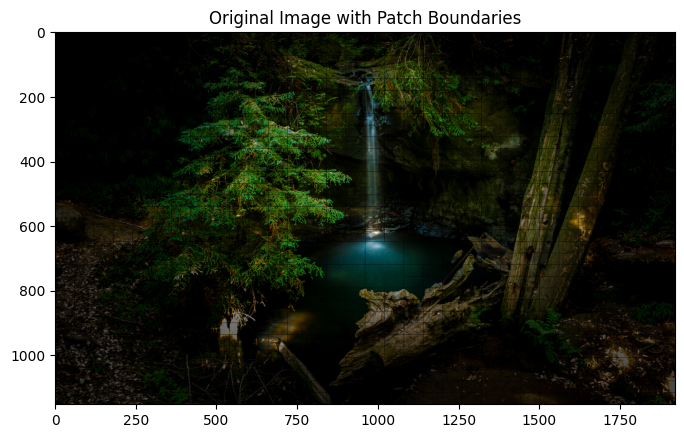

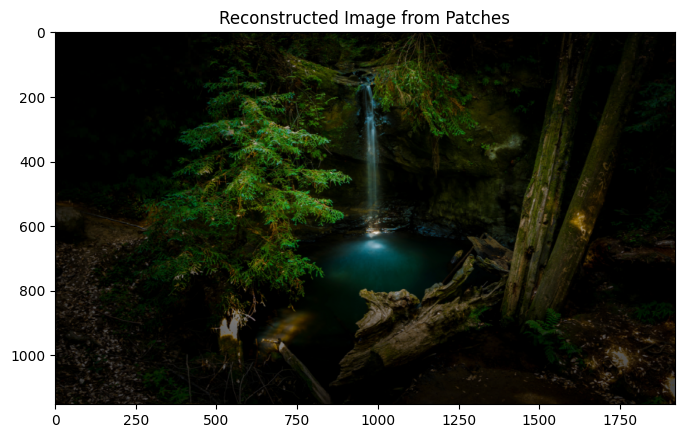

In [8]:
import cv2
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import os
import torch

# ---------------------------
# Helper Functions
# ---------------------------
def gaussian_blur(image, kernel_size):
    """Applies Gaussian blur with a square kernel."""
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def edge_detection(image, tl, th):
    """Converts image to grayscale (if needed) and applies Canny edge detection."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    edges = cv2.Canny(gray, tl, th)
    return edges

def quadtree_partition(edge_img, x, y, w, h, current_depth, max_depth, threshold, min_size=32):
    """
    Recursively partitions the image region [x, y, w, h] using a quadtree.
    Returns a list of patch coordinates (x, y, w, h).
    """
    patches = []
    # Stop if the patch is too small.
    if w <= min_size or h <= min_size:
        patches.append((x, y, w, h))
        return patches

    # Count edge pixels.
    patch_edges = edge_img[y:y+h, x:x+w]
    edge_count = np.count_nonzero(patch_edges)
    
    # Stop subdividing if edge count is low or maximum depth reached.
    if edge_count <= threshold or current_depth >= max_depth:
        patches.append((x, y, w, h))
    else:
        mid_x = x + w // 2
        mid_y = y + h // 2
        # Top-left
        patches += quadtree_partition(edge_img, x, y, mid_x - x, mid_y - y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Top-right
        patches += quadtree_partition(edge_img, mid_x, y, x + w - mid_x, mid_y - y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Bottom-left
        patches += quadtree_partition(edge_img, x, mid_y, mid_x - x, y + h - mid_y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Bottom-right
        patches += quadtree_partition(edge_img, mid_x, mid_y, x + w - mid_x, y + h - mid_y,
                                      current_depth + 1, max_depth, threshold, min_size)
    return patches

def sort_patches_traditional(patches):
    """
    Sorts patches in traditional reading order: top-to-bottom, left-to-right.
    Each patch is a tuple (x, y, w, h); we sort by y first then x.
    """
    return sorted(patches, key=lambda p: (p[1], p[0]))




def resize_patch(image, patch, Pm, padding=2):
    """
    Extracts the patch (x, y, w, h) from the image and resizes it.
    - Resizes the patch to Pm × Pm for uniform processing.
    - Expands it by padding with edge-aware extensions (mirroring edge pixels).
    - Returns the padded patch of size (Pm + 2*padding) × (Pm + 2*padding).

    If padding=0, it simply returns the resized patch.
    """
    x, y, w, h = patch
    patch_img = image[y:y+h, x:x+w]

    # Resize patch to Pm × Pm
    resized_center = cv2.resize(patch_img, (Pm, Pm), interpolation=cv2.INTER_AREA)

    # If padding is 0, return the resized patch directly
    if padding == 0:
        return resized_center

    # Define new padded size
    padded_size = Pm + 2 * padding
    padded_patch = np.zeros((padded_size, padded_size, 3), dtype=image.dtype)

    # Insert resized patch in the center
    padded_patch[padding:padding+Pm, padding:padding+Pm] = resized_center

    # Edge-aware padding using mirroring or replication
    # Top and bottom padding
    padded_patch[:padding, padding:padding+Pm] = resized_center[0:1, :, :]  # Copy top row
    padded_patch[-padding:, padding:padding+Pm] = resized_center[-1:, :, :]  # Copy bottom row

    # Left and right padding
    padded_patch[padding:padding+Pm, :padding] = resized_center[:, 0:1, :]  # Copy left column
    padded_patch[padding:padding+Pm, -padding:] = resized_center[:, -1:, :]  # Copy right column

    # Corner regions (copy nearest edge pixels)
    padded_patch[:padding, :padding] = resized_center[0, 0]  # Top-left corner
    padded_patch[:padding, -padding:] = resized_center[0, -1]  # Top-right corner
    padded_patch[-padding:, :padding] = resized_center[-1, 0]  # Bottom-left corner
    padded_patch[-padding:, -padding:] = resized_center[-1, -1]  # Bottom-right corner

    return padded_patch


def drop_last_or_pad_patch_info(patch_info, L, patch_size, dtype):
    """
    Given a list of patch_info dictionaries, drops extra patches (if > L) or pads with dummy patches
    so that the final list length equals L.
    """
    num = len(patch_info)
    if num > L:
        patch_info = patch_info[:L]  # Keep only the first L patches
    elif num < L:
        # Create a dummy patch (black image)
        if len(patch_info) > 0 and len(patch_info[0]['resized_patch'].shape) == 3:
            dummy_patch = np.zeros((patch_size, patch_size, 3), dtype=dtype)
        else:
            dummy_patch = np.zeros((patch_size, patch_size), dtype=dtype)
        for _ in range(L - num):
            patch_info.append({
                'id': -1,
                'coords': (-1, -1, 0, 0),
                'orig_patch': dummy_patch,
                'resized_patch': dummy_patch
            })
    return patch_info

def draw_patch_boundaries(image, patch_info):
    """
    Draws rectangle boundaries on a copy of the image using patch coordinates.
    """
    image_copy = image.copy()
    for info in patch_info:
        x, y, w, h = info['coords']
        # Skip dummy patches.
        if x < 0 or y < 0:
            continue
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 0, 0), 1)
    return image_copy



def save_patch_info_bin(coord_file, patch_info, rows, cols, original_shape):
    """
    Saves grid size, original image shape, number of valid patches, and patch ratio exponents to a binary file.
    
    For each valid patch (where patch_info['coords'][0] >= 0), only one number is saved:
        r_i = log2(H / h_i)
    where H is the original image height and h_i is the patch's height.
    """
    H, W, C = original_shape
    # Filter valid patches (only those with valid coordinates)
    valid_patches = [info for info in patch_info if info['coords'][0] >= 0]
    num_patches = len(valid_patches)

    valid_coords = [info['coords'] for info in patch_info if info['coords'][0] >= 0]
    
    
    # Compute ratio exponent for each valid patch (using h from (x, y, w, h))
    ratio_exponents = np.array(
        [int(np.log2(H / info['coords'][3])) for info in valid_patches],
        dtype=np.uint8
    )

    
    with open(coord_file, "wb") as f:
        # Save grid size and original image shape
        np.array([rows, cols], dtype=np.uint16).tofile(f)
        np.array(original_shape, dtype=np.uint16).tofile(f)
        # Save number of valid patches
        np.array([num_patches], dtype=np.uint16).tofile(f)
        # Save the ratio exponents (1 byte per patch)
        ratio_exponents.tofile(f)
    print("Saved minimal patch info to", coord_file)



def load_patch_info_bin(coord_file):
    """
    Loads grid size, original image shape, number of valid patches, and reconstructs patch coordinates.
    Optimized version that maintains the exact same behavior and results as the original function.
    
    Returns:
        patch_coords: A NumPy array of shape (num_patches, 4) containing (x, y, wi, hi) for each patch.
        rows, cols, original_shape
    """
    with open(coord_file, "rb") as f:
        # Read grid size and original image shape
        rows, cols = np.fromfile(f, dtype=np.uint16, count=2)
        original_shape = tuple(np.fromfile(f, dtype=np.uint16, count=3))
        # Read number of valid patches
        num_patches = np.fromfile(f, dtype=np.uint16, count=1)[0]
        # Read ratio exponents (one byte each)
        ratio_exponents = np.fromfile(f, dtype=np.uint8, count=num_patches)
    
    H, W, C = original_shape
    patch_coords = np.zeros((num_patches, 4), dtype=np.uint16)
    
    # Create occupancy matrix of the full image size
    occupancy = np.zeros((H, W), dtype=np.uint8)
    
    # Track the next position to start scanning from
    next_scan_y, next_scan_x = 0, 0
    
    for i, ri in enumerate(ratio_exponents):
        hi = H // (2 ** ri)
        wi = W // (2 ** ri)
        
        # Start scanning from where we left off
        y = next_scan_y
        x = next_scan_x
        placed = False
        
        # Scan in row-major order
        while y <= H - hi and not placed:
            while x <= W - wi and not placed:
                # Use a faster check first - if the top-left corner is occupied, skip
                if occupancy[y, x] == 0:
                    # Only do the full region check if the corner is free
                    region_free = True
                    
                    # Check row by row instead of the whole region at once
                    for dy in range(hi):
                        if not region_free:
                            break
                        # Check if the row is all zeros (using numpy's all)
                        if not np.all(occupancy[y+dy, x:x+wi] == 0):
                            region_free = False
                    
                    if region_free:
                        # Place the patch here
                        patch_coords[i] = (x, y, wi, hi)
                        
                        # Mark the region as occupied
                        for dy in range(hi):
                            occupancy[y+dy, x:x+wi] = 1
                        
                        # Remember where to start next time (next pixel in row-major order)
                        next_scan_x = x + 1
                        next_scan_y = y
                        if next_scan_x > W - wi:
                            next_scan_x = 0
                            next_scan_y = y + 1
                        
                        placed = True
                
                x += 1
            
            if not placed:
                y += 1
                x = 0
        
        if not placed:
            raise ValueError(f"Unable to place patch {i} with ratio exponent {ri}")
    
    
    return patch_coords, rows, cols, original_shape

def arrange_patches_in_grid_from_info(patch_info, patch_size):
    """
    Arranges a list of patch dictionaries (each with a 'resized_patch' of size (patch_size x patch_size))
    into a grid image. This function computes rows and columns so that the grid dimensions are multiples
    of 128 and match the expected resolution.
    
    For example, with patch_size = 32 (i.e. Pm=28 and padding=2), L=192 patches, the grid will be:
      - rows = 16 (i.e. 16 * 32 = 512 pixels in one dimension)
      - cols = 12 (i.e. 12 * 32 = 384 pixels in the other dimension)
    """
    L = len(patch_info)
    # Determine a base size using 128 as a reference (each 128 block fits patch_size pixels)
    base_size = 128 // patch_size  # For patch_size=32, base_size=4
    rows = base_size
    while rows * rows < L:
        rows += base_size
    cols = math.ceil(L / rows)
    # Adjust rows and cols so that the grid dimensions are multiples of (128 // patch_size)
    factor = 128 // patch_size
    rows = math.ceil((rows * patch_size) / 128) * factor
    cols = math.ceil((cols * patch_size) / 128) * factor

    grid_height = rows * patch_size
    grid_width = cols * patch_size

    grid_img = np.zeros((grid_height, grid_width, 3), dtype=np.uint8)
    for idx, info in enumerate(patch_info):
        row = idx // cols
        col = idx % cols
        grid_img[row * patch_size:(row+1) * patch_size, col * patch_size:(col+1) * patch_size] = info['resized_patch']
    return grid_img, rows, cols

# ---------------------------
# Encoder Routine
# ---------------------------
def encode_image_adaptive(image, kernel_size=1, tl=100, th=200, v=50, H=5, Pm=28, L=192,
                          grid_image_file="patches_grid.png", coord_file="patch_coords.bin", padding=2):
    """
    Encoder:
      - Computes adaptive patches using a quadtree.
      - Resizes patches to a fixed size with added padding.
      - Pads (or drops) patch_info so that exactly L patches are arranged.
      - Arranges patches into a grid whose dimensions are multiples of 128.
      - Saves the grid image and patch coordinate info.
    """
    # Stage 1: Preprocessing
    blurred = gaussian_blur(image, kernel_size)
    edges = edge_detection(blurred, tl, th)
    
    # Stage 2: Quadtree partitioning
    h_img, w_img = edges.shape[:2]
    patches_coords = quadtree_partition(edges, 0, 0, w_img, h_img, 0, H, v, min_size=32)
    
    # Stage 3: Sort patches in reading order
    sorted_coords = sort_patches_traditional(patches_coords)
    #sorted_coords = sort_patches_by_morton(patches_coords)
    
    # Stage 4: Build patch_info list (store coordinates, original patch, and resized (padded) patch)
    patch_info = []
    for idx, coord in enumerate(sorted_coords):
        x, y, w, h = coord
        orig_patch = image[y:y+h, x:x+w]
        resized_patch = resize_patch(image, coord, Pm, padding)
        patch_info.append({
            'id': idx,
            'coords': coord,
            'orig_patch': orig_patch,
            'resized_patch': resized_patch
        })
    print("Number of adaptive patches created:", len(patch_info))

    if L is None:
        L = len(patch_info)
    
    # The effective patch size after padding
    effective_patch_size = Pm + 2 * padding
    patch_info = drop_last_or_pad_patch_info(patch_info, L, effective_patch_size, image.dtype)
    
    # Stage 5: Arrange patches into a grid.
    grid_img, rows, cols = arrange_patches_in_grid_from_info(patch_info, effective_patch_size)
    #print(f"Final Grid Size: {grid_img.shape[1]} x {grid_img.shape[0]} (Width x Height)")
    print(f"Final Grid Size: {rows * effective_patch_size} x {cols * effective_patch_size} (Multiple of 128)")
    
    # Stage 6: Save grid image and coordinate file.
    cv2.imwrite(grid_image_file, grid_img)
    print("Saved grid image to", grid_image_file)


    save_patch_info_bin(coord_file, patch_info, rows, cols, image.shape)
    
    # (Optional) Display the results.
    # grid_img_rgb = cv2.cvtColor(grid_img, cv2.COLOR_BGR2RGB)
    # plt.figure(figsize=(8,8))
    # plt.imshow(grid_img_rgb)
    # plt.title("Adaptive Patching Grid")
    # plt.show()
    
    image_with_boundaries = draw_patch_boundaries(image, patch_info)
    image_with_boundaries_rgb = cv2.cvtColor(image_with_boundaries, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,8))
    plt.imshow(image_with_boundaries_rgb)
    plt.title("Original Image with Patch Boundaries")
    plt.show()

# ---------------------------
# Decoder Routine
# ---------------------------
def decode_image_adaptive(grid_image_file="patches_grid.png", coord_file="patch_coords.bin", Pm=28, padding=2):
    """
    Decoder:
      - Loads the grid image and patch coordinate info.
      - Splits the grid image back into patches.
      - Uses stored coordinates to resize each patch back to its original size.
      - Reconstructs the original image.
    """
    grid_img = cv2.imread(grid_image_file)
    if grid_img is None:
        raise ValueError("Grid image not found at " + grid_image_file)
    
    effective_patch_size = Pm + 2 * padding
    coords, rows, cols, original_shape = load_patch_info_bin(coord_file)
    L = coords.shape[0]
    
    # Split grid image into patches.
    grid_patches = []
    for r in range(rows):
        for c in range(cols):
            idx = r * cols + c
            if idx >= L:
                break
            patch = grid_img[r*effective_patch_size:(r+1)*effective_patch_size,
                              c*effective_patch_size:(c+1)*effective_patch_size]
            grid_patches.append(patch)
    
    # Reconstruct the original image.
    reconstructed = np.zeros(original_shape, dtype=grid_img.dtype)
    for idx, patch in enumerate(grid_patches):
        x, y, w, h = coords[idx]
        if x < 0 or y < 0 or w == 0 or h == 0:
            continue
        cropped_patch = patch[padding:padding+Pm, padding:padding+Pm]
        if cropped_patch.size == 0:
            continue
        patch_resized = cv2.resize(cropped_patch, (w, h), interpolation=cv2.INTER_AREA)
        reconstructed[y:y+h, x:x+w] = patch_resized
    
    reconstructed_rgb = cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,8))
    plt.imshow(reconstructed_rgb)
    plt.title("Reconstructed Image from Patches")
    plt.show()

    reconstructed_tensor = torch.from_numpy(reconstructed_rgb / 255.0).permute(2, 0, 1).unsqueeze(0).float()
    
    return reconstructed_tensor
    
   

# ---------------------------
# Main Routine
# ---------------------------
if __name__ == "__main__":
    # Change this image path as needed.
    image_path = 'Datasets/Kodak/kodim23.png'
    image_path = 'Datasets/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR/0852.png'
    #image_path = 'Datasets/Clic2021/01.png'
    #image_path = 'Datasets/Kodak/kodim25.jpeg'


    # image = cv2.imread(image_path)


    input_image, image_name= load_single_image(image_path)
    resized_image_np = input_image.squeeze(0).permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    resized_image_np = (resized_image_np * 255).astype(np.uint8)  # Convert to uint8 for OpenCV
    # Convert RGB to BGR for OpenCV compatibility
    image = cv2.cvtColor(resized_image_np, cv2.COLOR_RGB2BGR)


    if image is None:
        raise ValueError("Input image not found at " + image_path)
    
    
    encode_image_adaptive(image,
                          kernel_size=1,
                          tl=100, th=200,
                          v=50,       # quadtree edge threshold
                          H=5,        # maximum quadtree depth
                          Pm=28,      # base patch size before padding
                          L=None,      # number of patches in the grid   (If None, it will be set to the number of adaptive patches)
                          grid_image_file="patches_grid.png",
                          coord_file="patch_coords.bin",
                          padding=2)
    
    reconstructed_image = decode_image_adaptive(grid_image_file="patches_grid.png",
                                                  coord_file="patch_coords.bin",
                                                  Pm=28,
                                                  padding=2)


Optimized using numba

Number of adaptive patches created: 3049
Final Grid Size: 1792 x 1792 (Multiple of 128)
Saved grid image to patches_grid.png
Saved minimal patch info to patch_coords.bin


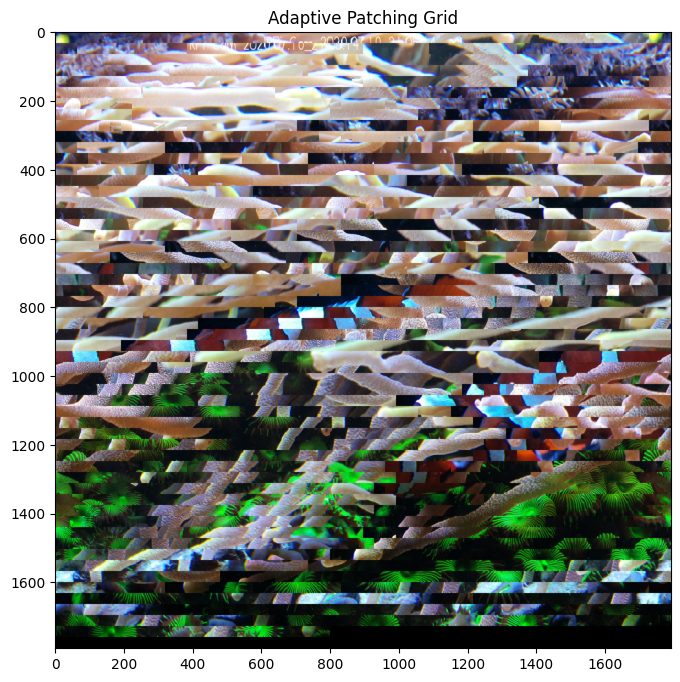

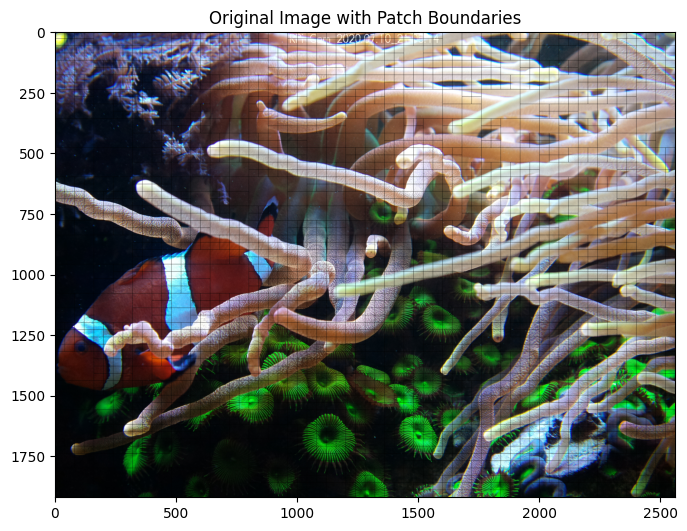

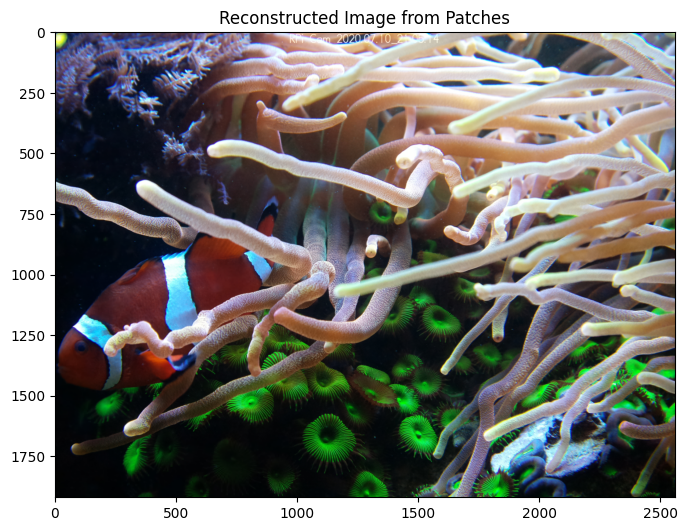

In [18]:
import cv2
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import os
import torch
import numba

# ---------------------------
# Helper Functions
# ---------------------------
def gaussian_blur(image, kernel_size):
    """Applies Gaussian blur with a square kernel."""
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def edge_detection(image, tl, th):
    """Converts image to grayscale (if needed) and applies Canny edge detection."""
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    edges = cv2.Canny(gray, tl, th)
    return edges

def quadtree_partition(edge_img, x, y, w, h, current_depth, max_depth, threshold, min_size=32):
    """
    Recursively partitions the image region [x, y, w, h] using a quadtree.
    Returns a list of patch coordinates (x, y, w, h).
    """
    patches = []
    # Stop if the patch is too small.
    if w <= min_size or h <= min_size:
        patches.append((x, y, w, h))
        return patches

    # Count edge pixels.
    patch_edges = edge_img[y:y+h, x:x+w]
    edge_count = np.count_nonzero(patch_edges)
    
    # Stop subdividing if edge count is low or maximum depth reached.
    if edge_count <= threshold or current_depth >= max_depth:
        patches.append((x, y, w, h))
    else:
        mid_x = x + w // 2
        mid_y = y + h // 2
        # Top-left
        patches += quadtree_partition(edge_img, x, y, mid_x - x, mid_y - y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Top-right
        patches += quadtree_partition(edge_img, mid_x, y, x + w - mid_x, mid_y - y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Bottom-left
        patches += quadtree_partition(edge_img, x, mid_y, mid_x - x, y + h - mid_y,
                                      current_depth + 1, max_depth, threshold, min_size)
        # Bottom-right
        patches += quadtree_partition(edge_img, mid_x, mid_y, x + w - mid_x, y + h - mid_y,
                                      current_depth + 1, max_depth, threshold, min_size)
    return patches

def sort_patches_traditional(patches):
    """
    Sorts patches in traditional reading order: top-to-bottom, left-to-right.
    Each patch is a tuple (x, y, w, h); we sort by y first then x.
    """
    return sorted(patches, key=lambda p: (p[1], p[0]))




def resize_patch(image, patch, Pm, padding=2):
    """
    Extracts the patch (x, y, w, h) from the image and resizes it.
    - Resizes the patch to Pm × Pm for uniform processing.
    - Expands it by padding with edge-aware extensions (mirroring edge pixels).
    - Returns the padded patch of size (Pm + 2*padding) × (Pm + 2*padding).

    If padding=0, it simply returns the resized patch.
    """
    x, y, w, h = patch
    patch_img = image[y:y+h, x:x+w]

    # Resize patch to Pm × Pm
    resized_center = cv2.resize(patch_img, (Pm, Pm), interpolation=cv2.INTER_AREA)

    # If padding is 0, return the resized patch directly
    if padding == 0:
        return resized_center

    # Define new padded size
    padded_size = Pm + 2 * padding
    padded_patch = np.zeros((padded_size, padded_size, 3), dtype=image.dtype)

    # Insert resized patch in the center
    padded_patch[padding:padding+Pm, padding:padding+Pm] = resized_center

    # Edge-aware padding using mirroring or replication
    # Top and bottom padding
    padded_patch[:padding, padding:padding+Pm] = resized_center[0:1, :, :]  # Copy top row
    padded_patch[-padding:, padding:padding+Pm] = resized_center[-1:, :, :]  # Copy bottom row

    # Left and right padding
    padded_patch[padding:padding+Pm, :padding] = resized_center[:, 0:1, :]  # Copy left column
    padded_patch[padding:padding+Pm, -padding:] = resized_center[:, -1:, :]  # Copy right column

    # Corner regions (copy nearest edge pixels)
    padded_patch[:padding, :padding] = resized_center[0, 0]  # Top-left corner
    padded_patch[:padding, -padding:] = resized_center[0, -1]  # Top-right corner
    padded_patch[-padding:, :padding] = resized_center[-1, 0]  # Bottom-left corner
    padded_patch[-padding:, -padding:] = resized_center[-1, -1]  # Bottom-right corner

    return padded_patch


def drop_last_or_pad_patch_info(patch_info, L, patch_size, dtype):
    """
    Given a list of patch_info dictionaries, drops extra patches (if > L) or pads with dummy patches
    so that the final list length equals L.
    """
    num = len(patch_info)
    if num > L:
        patch_info = patch_info[:L]  # Keep only the first L patches
    elif num < L:
        # Create a dummy patch (black image)
        if len(patch_info) > 0 and len(patch_info[0]['resized_patch'].shape) == 3:
            dummy_patch = np.zeros((patch_size, patch_size, 3), dtype=dtype)
        else:
            dummy_patch = np.zeros((patch_size, patch_size), dtype=dtype)
        for _ in range(L - num):
            patch_info.append({
                'id': -1,
                'coords': (-1, -1, 0, 0),
                'orig_patch': dummy_patch,
                'resized_patch': dummy_patch
            })
    return patch_info

def draw_patch_boundaries(image, patch_info):
    """
    Draws rectangle boundaries on a copy of the image using patch coordinates.
    """
    image_copy = image.copy()
    for info in patch_info:
        x, y, w, h = info['coords']
        # Skip dummy patches.
        if x < 0 or y < 0:
            continue
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), (0, 0, 0), 1)
    return image_copy



def save_patch_info_bin(coord_file, patch_info, rows, cols, original_shape):
    """
    Saves grid size, original image shape, number of valid patches, and patch ratio exponents to a binary file.
    
    For each valid patch (where patch_info['coords'][0] >= 0), only one number is saved:
        r_i = log2(H / h_i)
    where H is the original image height and h_i is the patch's height.
    """
    H, W, C = original_shape
    # Filter valid patches (only those with valid coordinates)
    valid_patches = [info for info in patch_info if info['coords'][0] >= 0]
    num_patches = len(valid_patches)

    valid_coords = [info['coords'] for info in patch_info if info['coords'][0] >= 0]
    
    # Compute ratio exponent for each valid patch (using h from (x, y, w, h))
    ratio_exponents = np.array(
        [int(np.log2(H / info['coords'][3])) for info in valid_patches],
        dtype=np.uint8
    )

    
    with open(coord_file, "wb") as f:
        # Save grid size and original image shape
        np.array([rows, cols], dtype=np.uint16).tofile(f)
        np.array(original_shape, dtype=np.uint16).tofile(f)
        # Save number of valid patches
        np.array([num_patches], dtype=np.uint16).tofile(f)
        # Save the ratio exponents (1 byte per patch)
        ratio_exponents.tofile(f)
    print("Saved minimal patch info to", coord_file)




@numba.njit
def find_free_region(occupancy, H, W, hi, wi, start_y, start_x):
    """
    Scans the occupancy matrix in row-major order starting at (start_y, start_x)
    and returns the first (y, x) position where the region of size (hi, wi) is free.
    Returns (-1, -1) if no free region is found.
    """
    for y in range(start_y, H - hi + 1):
        # When starting in the first candidate row, start x from start_x; otherwise from 0.
        x_start = start_x if y == start_y else 0
        for x in range(x_start, W - wi + 1):
            region_free = True
            for dy in range(hi):
                for dx in range(wi):
                    if occupancy[y + dy, x + dx] != 0:
                        region_free = False
                        break  # break inner dx loop
                if not region_free:
                    break  # break dy loop
            if region_free:
                return y, x
    return -1, -1

@numba.njit
def mark_region(occupancy, y, x, hi, wi):
    """
    Marks the region in the occupancy matrix (of size hi x wi starting at (y, x))
    as occupied (i.e. sets the region to 1).
    """
    for dy in range(hi):
        for dx in range(wi):
            occupancy[y + dy, x + dx] = 1

def load_patch_info_bin(coord_file):
    """
    Loads grid size, original image shape, number of valid patches, and reconstructs patch coordinates.
    This version uses Numba to accelerate the inner loops while preserving the exact logic and results.
    
    Returns:
        patch_coords: A NumPy array of shape (num_patches, 4) containing (x, y, wi, hi) for each patch.
        rows, cols, original_shape
    """
    with open(coord_file, "rb") as f:
        # Read grid size and original image shape
        rows, cols = np.fromfile(f, dtype=np.uint16, count=2)
        original_shape = tuple(np.fromfile(f, dtype=np.uint16, count=3))
        # Read number of valid patches
        num_patches = np.fromfile(f, dtype=np.uint16, count=1)[0]
        # Read ratio exponents (one byte each)
        ratio_exponents = np.fromfile(f, dtype=np.uint8, count=num_patches)
    
    H, W, C = original_shape
    patch_coords = np.zeros((num_patches, 4), dtype=np.uint16)
    
    # Create occupancy matrix of the full image size
    occupancy = np.zeros((H, W), dtype=np.uint8)
    
    # Track next scanning start position (to avoid re-scanning from 0,0 every time)
    next_scan_y, next_scan_x = 0, 0
    
    for i, ri in enumerate(ratio_exponents):
        hi = H // (2 ** ri)
        wi = W // (2 ** ri)
        
        # Use the compiled function to quickly find a free region
        y, x = find_free_region(occupancy, H, W, hi, wi, next_scan_y, next_scan_x)
        if y == -1:
            raise ValueError(f"Unable to place patch {i} with ratio exponent {ri}")
        
        # Save the patch coordinate as (x, y, wi, hi)
        patch_coords[i] = (x, y, wi, hi)
        
        # Mark the region as occupied using compiled code
        mark_region(occupancy, y, x, hi, wi)
        
        # Update next scanning position: move right one pixel;
        # if not enough space remains horizontally, move to the next row.
        if x + 1 <= W - wi:
            next_scan_x = x + 1
            next_scan_y = y
        else:
            next_scan_x = 0
            next_scan_y = y + 1
    
    return patch_coords, rows, cols, original_shape


def arrange_patches_in_grid_from_info(patch_info, patch_size):
    """
    Arranges a list of patch dictionaries (each with a 'resized_patch' of size (patch_size x patch_size))
    into a grid image. This function computes rows and columns so that the grid dimensions are multiples
    of 128 and match the expected resolution.
    
    For example, with patch_size = 32 (i.e. Pm=28 and padding=2), L=192 patches, the grid will be:
      - rows = 16 (i.e. 16 * 32 = 512 pixels in one dimension)
      - cols = 12 (i.e. 12 * 32 = 384 pixels in the other dimension)
    """
    L = len(patch_info)
    # Determine a base size using 128 as a reference (each 128 block fits patch_size pixels)
    base_size = 128 // patch_size  # For patch_size=32, base_size=4
    rows = base_size
    while rows * rows < L:
        rows += base_size
    cols = math.ceil(L / rows)
    # Adjust rows and cols so that the grid dimensions are multiples of (128 // patch_size)
    factor = 128 // patch_size
    rows = math.ceil((rows * patch_size) / 128) * factor
    cols = math.ceil((cols * patch_size) / 128) * factor

    grid_height = rows * patch_size
    grid_width = cols * patch_size

    grid_img = np.zeros((grid_height, grid_width, 3), dtype=np.uint8)
    for idx, info in enumerate(patch_info):
        row = idx // cols
        col = idx % cols
        grid_img[row * patch_size:(row+1) * patch_size, col * patch_size:(col+1) * patch_size] = info['resized_patch']
    return grid_img, rows, cols

# ---------------------------
# Encoder Routine
# ---------------------------
def encode_image_adaptive(image, kernel_size=1, tl=100, th=200, v=50, H=5, Pm=28, L=192,
                          grid_image_file="patches_grid.png", coord_file="patch_coords.bin", padding=2):
    """
    Encoder:
      - Computes adaptive patches using a quadtree.
      - Resizes patches to a fixed size with added padding.
      - Pads (or drops) patch_info so that exactly L patches are arranged.
      - Arranges patches into a grid whose dimensions are multiples of 128.
      - Saves the grid image and patch coordinate info.
    """
    # Stage 1: Preprocessing
    blurred = gaussian_blur(image, kernel_size)
    edges = edge_detection(blurred, tl, th)
    
    # Stage 2: Quadtree partitioning
    h_img, w_img = edges.shape[:2]
    patches_coords = quadtree_partition(edges, 0, 0, w_img, h_img, 0, H, v, min_size=32)
    
    # Stage 3: Sort patches in reading order
    sorted_coords = sort_patches_traditional(patches_coords)
    #sorted_coords = sort_patches_by_morton(patches_coords)
    
    # Stage 4: Build patch_info list (store coordinates, original patch, and resized (padded) patch)
    patch_info = []
    for idx, coord in enumerate(sorted_coords):
        x, y, w, h = coord
        orig_patch = image[y:y+h, x:x+w]
        resized_patch = resize_patch(image, coord, Pm, padding)
        patch_info.append({
            'id': idx,
            'coords': coord,
            'orig_patch': orig_patch,
            'resized_patch': resized_patch
        })
    print("Number of adaptive patches created:", len(patch_info))

    if L is None:
        L = len(patch_info)
    
    # The effective patch size after padding
    effective_patch_size = Pm + 2 * padding
    patch_info = drop_last_or_pad_patch_info(patch_info, L, effective_patch_size, image.dtype)
    
    # Stage 5: Arrange patches into a grid.
    grid_img, rows, cols = arrange_patches_in_grid_from_info(patch_info, effective_patch_size)
    #print(f"Final Grid Size: {grid_img.shape[1]} x {grid_img.shape[0]} (Width x Height)")
    print(f"Final Grid Size: {rows * effective_patch_size} x {cols * effective_patch_size} (Multiple of 128)")
    
    # Stage 6: Save grid image and coordinate file.
    cv2.imwrite(grid_image_file, grid_img)
    print("Saved grid image to", grid_image_file)


    save_patch_info_bin(coord_file, patch_info, rows, cols, image.shape)
    
    # (Optional) Display the results.
    grid_img_rgb = cv2.cvtColor(grid_img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,8))
    plt.imshow(grid_img_rgb)
    plt.title("Adaptive Patching Grid")
    plt.show()
    
    image_with_boundaries = draw_patch_boundaries(image, patch_info)
    image_with_boundaries_rgb = cv2.cvtColor(image_with_boundaries, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,8))
    plt.imshow(image_with_boundaries_rgb)
    plt.title("Original Image with Patch Boundaries")
    plt.show()

# ---------------------------
# Decoder Routine
# ---------------------------
def decode_image_adaptive(grid_image_file="patches_grid.png", coord_file="patch_coords.bin", Pm=28, padding=2):
    """
    Decoder:
      - Loads the grid image and patch coordinate info.
      - Splits the grid image back into patches.
      - Uses stored coordinates to resize each patch back to its original size.
      - Reconstructs the original image.
    """
    grid_img = cv2.imread(grid_image_file)
    if grid_img is None:
        raise ValueError("Grid image not found at " + grid_image_file)
    
    effective_patch_size = Pm + 2 * padding
    coords, rows, cols, original_shape = load_patch_info_bin(coord_file)
    L = coords.shape[0]
    
    # Split grid image into patches.
    grid_patches = []
    for r in range(rows):
        for c in range(cols):
            idx = r * cols + c
            if idx >= L:
                break
            patch = grid_img[r*effective_patch_size:(r+1)*effective_patch_size,
                              c*effective_patch_size:(c+1)*effective_patch_size]
            grid_patches.append(patch)
    
    # Reconstruct the original image.
    reconstructed = np.zeros(original_shape, dtype=grid_img.dtype)
    for idx, patch in enumerate(grid_patches):
        x, y, w, h = coords[idx]
        if x < 0 or y < 0 or w == 0 or h == 0:
            continue
        cropped_patch = patch[padding:padding+Pm, padding:padding+Pm]
        if cropped_patch.size == 0:
            continue
        patch_resized = cv2.resize(cropped_patch, (w, h), interpolation=cv2.INTER_AREA)
        reconstructed[y:y+h, x:x+w] = patch_resized
    
    reconstructed_rgb = cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,8))
    plt.imshow(reconstructed_rgb)
    plt.title("Reconstructed Image from Patches")
    plt.show()

    reconstructed_tensor = torch.from_numpy(reconstructed_rgb / 255.0).permute(2, 0, 1).unsqueeze(0).float()
    
    return reconstructed_tensor
    
   

# ---------------------------
# Main Routine
# ---------------------------
if __name__ == "__main__":
    # Change this image path as needed.
    image_path = 'Datasets/Kodak/kodim23.png'
    #image_path = 'Datasets/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR/0842.png'
    image_path = 'Datasets/Clic2021/41.png'
    #image_path = 'Datasets/Kodak/kodim25.jpeg'
    image_path = 'Datasets/Additional/4.jpg'


    # image = cv2.imread(image_path)


    input_image, image_name= load_single_image(image_path)
    resized_image_np = input_image.squeeze(0).permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
    resized_image_np = (resized_image_np * 255).astype(np.uint8)  # Convert to uint8 for OpenCV
    # Convert RGB to BGR for OpenCV compatibility
    image = cv2.cvtColor(resized_image_np, cv2.COLOR_RGB2BGR)


    if image is None:
        raise ValueError("Input image not found at " + image_path)
    
    
    encode_image_adaptive(image,
                          kernel_size=1,
                          tl=100, th=200,
                          v=50,       # quadtree edge threshold
                          H=6,        # maximum quadtree depth
                          Pm=28,      # base patch size before padding
                          L=None,      # number of patches in the grid   (If None, it will be set to the number of adaptive patches)
                          grid_image_file="patches_grid.png",
                          coord_file="patch_coords.bin",
                          padding=2)
    
    reconstructed_image = decode_image_adaptive(grid_image_file="patches_grid.png",
                                                  coord_file="patch_coords.bin",
                                                  Pm=28,
                                                  padding=2)


In [19]:
import torch
import torch.nn.functional as F

def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1 * 255., img2 * 255.)
    psnr = 10 * torch.log10(255.0 ** 2 / mse)
    return psnr

# input_image = load_single_image(image_path)[0]
# reconstructed_image = load_single_image('reconstructed_image.png')[0]

psnr_value = calculate_psnr(input_image, reconstructed_image)

print(f"PSNR: {psnr_value:.2f} dB")

PSNR: 35.92 dB
